## Final Project Submission

Please fill out:
* Student name: Steven Rosa
* Student pace: part time
* Project review date/time: Monday 1 April 2019 11am ET
* Instructor name: Jeff Herman
* Blog post URL: https://towardsdatascience.com/cacator-cave-malvm-ff856966626

<a id = 'top'></a>

# Contents
- Summary
- [Libraries](#libraries)
- [A first look at the data](#obtain)
- [Cleaning the raw data](#scrub)
- [Exploratory data analysis](#explore)
 - [Character count and imperatives](#character_imperative)
 - [Address](#address)
 - [How good are the categories?](#prelim_model)
 - [Detour: improving the categories](#detour_cat)
 - [How useful will the Flohr score be?](#flohr)
- Modeling
 - [Model #1: Logistic Regression](#model1)
   - [Adjusting regularization parameter](#logreg_regparam)
   - [Cross validation](#logreg_cv)
   - [The final model](#logreg_final)
 - [Model #2: Decision tree](#model2)
   - [Tuning Hyperparameters](#tree_tuning_hypers)
   - [Tuning with Grid Search CV](#tree_grid_search)
   - [The final model](#tree_final)
 - [Model #3: Random forest](#model3)
   - [The final model](#forest_final)
 - [Model #4: Gradient boosting](#model4)
   - [Grid search](#boost_gs)
   - [The final model](#boost_final)
- [Conclusions](#conclusions)
   - [Comparisons of models](#concl_comparisons)
   - [Feature importance](#concl_features)
   - [Recommendations](#concl_recs)

# Summary

Pompeii was a bustling Roman town of about 20,000 people in 79CE at the moment when Mount Vesuvius erupted and buried the city in hot ash. All the residents were killed instantly but much of the town was left almost intact.

Excavators and tourists have been visiting the site for 250 years but much of the town remains unexcavated:

![unexcavatted.jpg](https://raw.githubusercontent.com/ssrosa/cacator_cave_malum/master/images/unexcavated.jpg)

(image [via](http://pompeiisites.org/en/press-kit-en/new-excavations-in-regio-v/))

Residents of the town scrawled graffiti all over the walls of the buildings. Archeologists have catalogued hundreds and hundreds of examples, much of it written in Vulgar Latin, a form of Latin not often seen in writing.

![gladiators.png](https://raw.githubusercontent.com/ssrosa/cacator_cave_malum/master/images/gladiators.png)

images [via](https://www.pompeiiinpictures.com/pompeiiinpictures/R1/1%2006%2015%20p4.htm) and [via](http://amphi-theatrum.de/1719.html)

In [258]:
#CIL IV #8056a: Severus versus Albanus
df.at['409', 'In English']

'Severus, F(reedman), 13 (victories)/Albanus, lefthanded, f(reedman) 19 (victories)'

Some of the graffiti, like the above, record the results of gladiator fights. Some boasts of the exploits of brothel visitors; some posts items for sale; some cites love poetry. To classify this graffiti could be useful for archeologists working in the areas of the town that haven't been excavated yet. And because only a few experts may be able to translate graffiti from Vulgar Latin into a modern language, it would be useful to have a classifier that worked without interpreting the content of graffiti.

Using a [data set of Pompeii graffiti by Alex Rose](https://core.tdar.org/dataset/445837/database-for-the-scratched-voices-begging-to-be-heard-the-graffiti-of-pompeii-and-today), can we build a classifier for the graffiti of Pompeii that ignores the textual content and it takes signals from data on location, number of characters, &c?

<a id ='libraries'></a>

# Libraries

In [1]:
import graffiti_functions #Import my custom functions
from graffiti_functions import write, write_scores, draw_graph
from graffiti_functions import plot_conf_matrix, keyword_matrix,  hyper, compare_hypers, plot_hypers

import numpy as np #For mathematical operations
import random                   #for generating random numbers for train/test split
import copy                     #for making deep copies of mutable objects
import time                     #for timing expensive operations
import pandas as pd #For working with DataFrames
from pandasql import sqldf #for manipulating DataFrames with SQL style queries

#############################
# PREPARING DATA FOR MODELING:
#To divide data when testing a trained model
from sklearn.model_selection import train_test_split 
#For scaling/normalizing, and for LabelEncoder and OneHotEncoder
from sklearn import preprocessing
#To turn categorical columns into sets of numerical columns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#####################
# LOGISTIC REGRESSION:
#To build regular logistic regression models
from sklearn.linear_model import LogisticRegression
#To build LRs with cross validation
from sklearn.linear_model import LogisticRegressionCV

################
# DECISION TREES:
#For building decision trees
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree 
#To find best combination of hyperparameters in decision trees
from sklearn.model_selection import GridSearchCV
#To evaluate accuracy of decision trees
from sklearn.model_selection import cross_val_score

##################
# ENSEMBLE METHODS:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

##################
# VISUALIZATION:
import matplotlib.pyplot as plt # For plotting data
import seaborn as sns #For drawing confusion matrices as heat maps

##################
# ASSESSING MODELS:
#To assess accuracy of logistic regression or decision trees
from sklearn.metrics import confusion_matrix 
#To iteratively append labels to cells in a confusion matrix
import itertools 
#To get accuracy, precision, recall, and F1 score (weighted accuracy) of a given confusion matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#To view the accuracy metrics for a given confusion matrix
from sklearn.metrics import classification_report

<a id = 'obtain'></a>

[(Back to top)](#top)

# A first look at the data

In [2]:
#Obtain the raw data
df_raw = pd.read_csv('graffiti.csv')

In [322]:
df_raw[df_raw['In English'].str.contains('burn')]

,CIL IV #,Reggio,Insula,Entrance,found?,In English,org.,Literacy (1-3),In org. language,Context type specific,...,Category,Written by,Work,Meter,Repetition,Foreign language,Image,Flohr Score,Socio-economic status,comments
76,1820,8,1,1,NaN,"Chius, I hope your haemorrhiods open up again,...",NaN,3.0,NaN,NaN,...,Insult,NaN,NaN,NaN,NaN,NaN,NaN,NaN,low,NaN
87,1882,8,1,1,NaN,"If you bugger an orderly, you will burn your cock",NaN,3.0,NaN,NaN,...,Insult,NaN,NaN,yes,NaN,NaN,NaN,NaN,low,NaN
118,1898,8,1,1,NaN,"Whoever is in love should not take hot baths, ...",NaN,3.0,NaN,NaN,...,Romantic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,low,NaN
450,1645,7,6,35,NaN,"If someone perhaps wanted to violate my girl, ...",NaN,3.0,NaN,NaN,...,Insult,NaN,NaN,yes,NaN,NaN,NaN,1.73,low,NaN
562,4966_4967,8,7,19,NaN,"What is happening? After you, my eyes, have dr...",NaN,3.0,NaN,NaN,...,Reference,Tibutinus,NaN,yes,NaN,NaN,NaN,NaN,medium,NaN
972,NaN,7,16,17,NaN,"Chaste nymph, burn!",NaN,3.0,NaN,staircase,...,Insult/Sexual,NaN,NaN,NaN,NaN,NaN,NaN,32.3,medium,NaN


<a id = 'scrub'></a>

[(Back to top)](#top)

# Cleaning the data

## Column by column

### 'CIL IV \#'

This is a designation given to each piece of graffiti. It helps to track graffiti from one project to another. It won't be useful for the classifier but I'll keep it help me find pictures and references to interesting graffiti.

In [3]:
df_raw['CIL IV #'] = df_raw['CIL IV #'].fillna(0)

### 'Reggio'

Archeologists have divided the town into several reggios. A few are still under investigation. Every piece of graffiti was found in a reggio.

In [31]:
df_raw['Reggio'].value_counts()

7      224
9      148
1      138
6      131
8      120
5      104
2       89
3       37
4        2
6_7      1
Name: Reggio, dtype: int64

In [32]:
print(df_raw['Reggio'].isna().sum())

57


In [4]:
#Fill NaN values
df_raw['Reggio'] = df_raw['Reggio'].fillna(0)
#Change 6_7 to 6
df_raw.at[994, 'Reggio'] = '6'
#Change data type
df_raw['Reggio'] = df_raw['Reggio'].astype('str')

Zero values can be filled later once more is known about the reggios.

### 'Insula'

Insulae were like apartment buildings. They often had small shops in street-facing units on the ground floor and apartments above. To allow for interior light and ventilation, the larger insulae had courtyards.

In [34]:
df_raw['Insula'].value_counts()

1        154
7        124
2        115
12        88
6         66
5         57
9         46
15        44
4         43
10        42
11        41
3         37
13        35
16        35
14        32
8         22
4_5        2
4_3        2
8b         1
12_13      1
1_5        1
9_10       1
Name: Insula, dtype: int64

In [35]:
df_raw['Insula'].isna().sum()

62

In [5]:
#Fill null values
df_raw['Insula'] = df_raw['Insula'].fillna(0)

#Replace the values with underscores
df_raw.at[985, 'Insula'] = '4'
df_raw.at[986, 'Insula'] = '4'
df_raw.at[983, 'Insula'] = '4'
df_raw.at[984, 'Insula'] = '4'
df_raw.at[988, 'Insula'] = '9'
df_raw.at[987, 'Insula'] = '8'
df_raw.at[982, 'Insula'] = '12'
df_raw.at[981, 'Insula'] = '1'

#Change data type
df_raw['Insula'] = df_raw['Insula'].astype('str')

### 'Entrance'

This column appears to refer to the unit within an insulae in which each graffito was found. Most entrances were numbered but a few were labelled with letters.

In [37]:
df_raw['Entrance'].value_counts()

1         127
3          79
18_20      63
4          51
20         37
5          32
6          32
2          30
10         30
17         27
19         25
11         23
7          22
2_5        20
15         19
8          17
22_29      17
i          14
26         13
3_6        12
16         12
12         12
35         11
21         11
43         11
18          9
3_4         9
9           8
40          5
8-Jan       5
         ... 
9-Jan       1
19-20       1
22-25       1
14_16       1
7_8         1
17-21       1
67_68       1
37          1
22-24       1
16-Jan      1
57          1
39          1
2_3         1
33_34       1
15-Jan      1
9_7         1
5_13        1
23-26       1
34_35       1
51          1
1_2         1
f           1
25_26       1
5_7         1
30          1
27-35       1
41          1
16-17       1
51_31       1
39-40       1
Name: Entrance, Length: 109, dtype: int64

In [6]:
#Fill null values
df_raw['Entrance'] = df_raw['Entrance'].fillna('unknown')

#Replace all values with underscores or hyphens
#Dict to fill values from 'Entrance'
entrance_replacements = dict()
entrance_values = df_raw['Entrance'].value_counts()

#Iterate over Entrance values to look for underscore and hyphen
#Make a dict with values to replace the _/- values in the dataframe
#I'm choosing to take the first numerical value from each pair
for index in entrance_values.index:
        if '_' in index:
            index_split = index.split('_')
            entrance_replacements[index] = index_split[0]
        elif '-' in index:
            index_split = index.split('-')
            entrance_replacements[index] = index_split[0]
            
df_raw['Entrance'] = df_raw['Entrance'].replace(entrance_replacements)

#Change 'F' to 'f'
df_raw.at[661, 'Entrance'] = df_raw.at[661, 'Entrance'].lower()
#Change '4/5/' to '4'
df_raw.at[6, 'Entrance'] = '4'
#Replace letters
df_raw['Entrance'] = df_raw['Entrance'].replace({'I': 'i',
                                                 '?': '0',
                                                'unknown': '0'})
#Change data type
df_raw['Entrance'] = df_raw['Entrance'].astype('str')

This is better, but it may have to be categorized.

### 'found?'

Not sure what the author of the data set had in mind with this column. It won't be useful here.

In [39]:
df_raw['found?'].isna().sum()

1034

In [7]:
#Can just be dropped
df_raw.drop(['found?'], axis = 1, inplace = True)

### 'In English'

This is the English translation of each graffito. It's the key to understanding how to classify the pieces of graffiti that we've got. It wouldn't be available for untranslated graffiti so the text itself can't be used in the  classifier.

In [41]:
df_raw['In English'].isna().sum()

8

In [8]:
#Fill nulls so that they can be read
df_raw['In English'] = df_raw['In English'].fillna('')

#Rows with null values or unhelpful 'CHECK' values
blank_indexes = df_raw.index[df_raw['In English'] == '']
check_indexes = df_raw.index[df_raw['In English'] == '[CHECK]']

#Drop the empty rows. They aren't useful if they don't have the English text of the graffiti.
df_raw.drop(blank_indexes, inplace = True)
df_raw.drop(check_indexes, inplace = True)

In [43]:
df_raw['In English'][20:]

20                        Daphnicus ... here with Felicla
21                              Here I fucked twice [...]
22      Long live whoever loves! Awar with him, who do...
23                         Staphylus ... here with Quieta
24                            Room of Rufinus. Greetings.
25      Even if you devour me up to my roots, still I ...
26                      It is not me, I do not laze about
27                                   And adressing him...
28      Primigenius [...] Mystes sends greetings to hi...
29          Hay brought the 18th of October, [...] pounds
30      Fortunatus will fuck you deep. Come and see, A...
31                                           Bye Jarinus!
32                                           Bye Jarinus!
33      We came here desiring, much more [we desire to...
34                                 Polycarpus has escaped
35      In Nuceria I have won 855 and a half (denarii)...
36      Accomodation for rent: room with three beds an...
37            

### 'org. '

Sources for some of the graffiti. Not useful here.

In [44]:
df_raw['org. '].value_counts()[:10]

?                                   170
Benefiel 2010a                        8
Varone 2002                           4
Varone 2011 288                       3
Cugusi 2008                           3
Milnor 2009                           2
Franklin jr. 1987, 102 and n 670      2
Milnor 2014 89-90                     2
Biville 2003                          2
Varone 2002 134-135                   2
Name: org. , dtype: int64

In [9]:
#Won't be useful here. Can be dropped.
df_raw.drop(['org. '], axis = 1, inplace = True)

### 'Literacy'

The author's assessment of how advanced the writing was.

In [46]:
df_raw['Literacy (1-3)'].value_counts()

2.0    592
3.0    444
1.0      2
Name: Literacy (1-3), dtype: int64

In [47]:
df_raw['Literacy (1-3)'].isna().sum()

1

In [10]:
#Rename column
df_raw = df_raw.rename(index=str, columns = {'Literacy (1-3)': 'Literacy'})

#Turn the few 1 values into 2s.
df_raw['Literacy'] = df_raw['Literacy'].replace({1.0: 2})

#Fill nulls
df_raw['Literacy'] = df_raw['Literacy'].fillna(2)

#Turn floats into integers
df_raw['Literacy'] = df_raw['Literacy'].astype('float').astype('int')

### 'In org. language'

Most of the graffiti is in Vulgar Latin but some is in Greek or other languages.

In [49]:
df_raw['In org. language'].value_counts().sum()

315

In [11]:
#Dropping 
df_raw.drop(['In org. language'], axis = 1, inplace = True)

### 'Context type general'

This is the type of building that the graffiti was found in.

In [51]:
df_raw['Context type general'].value_counts()

house           438
brothel          70
tabernae         69
palaestra        35
unit             27
bar              23
theatre          22
inn              19
Baths             9
bakery            9
amphitheatre      8
temple            7
apartment         6
shop              3
altar             2
Name: Context type general, dtype: int64

In [52]:
df_raw['Context type general'].isna().sum()

292

In [12]:
# No specific, no general, no reggio, insula
no_spec_no_gen = df_raw[df_raw['Context type specific'].isna() & df_raw['Context type general'].isna()]

no_spec_no_gen[(no_spec_no_gen['Reggio'] == '0') & (no_spec_no_gen['Insula'] == '0')].shape

#Must drop the 43 rows that don't have a reggio, insula, specfic context or general context
to_drop = no_spec_no_gen[(no_spec_no_gen['Reggio'] == '0') & (no_spec_no_gen['Insula'] == '0')]
df_raw.drop(to_drop.index, axis = 0, inplace = True)

#Maybe famous house can fill in for general context where it's missing?
famoushouse_nogen = df_raw[
    (df_raw['Famous House'].notna())
    & 
    (df_raw['Context type general'].isna())]

#Get indexes of all rows without a gen context but with a famous house
indexes = famoushouse_nogen.index

famoushouse_gencontexts = {
    'Praedia ': 'building',
    'Basilica': 'basilica',
    'House of': 'house',
    'house of': 'house',
    'Villa of': 'house',
    'Building': 'building',
    'near the Porta Vesuvio': 'necropolis',
    'Workshop': 'workshop'
}

#Replace gen context with the building type from its famous house
#Iterate over all the rows which have a famous house but lack a gen context
for index in indexes:
    #Iterate over the keys of famous houses
    for key, val in famoushouse_gencontexts.items():
        #If the row's famous house matches one from the dict
        if key in df_raw.at[index, 'Famous House']:
            #Fill missing gen context value with value from dict
            df_raw.at[index, 'Context type general'] = val
            
#Noticed that Bar of Sotericus has gen context of "house"
indexes = df_raw[df_raw['Famous House'] == 'Bar of Sotericus']['Context type general']
#Replace 'house' with 'bar' for these
for index in indexes.index:
    df_raw.at[index, 'Context type general'] = 'bar'
    
#Noticed that 'Outside Porta Marina' had two NaN gen contexts to fix
#Will drop these because they're missing too many columns
df_raw.drop(['997', '998'], axis = 0, inplace = True)

#change all building types for spec context "workshop" to gen context "workshop"
indexes = df_raw[df_raw['Context type specific'] == 'workshop']
for index in indexes.index:
    df_raw.at[index, 'Context type general'] = 'workshop'

#Same for 'Workshop'
indexes = df_raw[df_raw['Context type specific'] == 'Workshop']
for index in indexes.index:
    df_raw.at[index, 'Context type general'] = 'workshop'

#Specific context "dining room" to general context "house"
indexes = df_raw[
    (df_raw['Context type specific'] == 'dining room')
    & 
    (df_raw['Context type general'].isna())]
for index in indexes.index:
    df_raw.at[index, 'Context type general'] = 'house'

#Spec context "shop" to general context "shop"
indexes = df_raw[
    (df_raw['Context type specific'] == 'shop')
    & 
    (df_raw['Context type general'].isna())]
for index in indexes.index:
    df_raw.at[index, 'Context type general'] = 'shop'
    
#Spec context "kitchen" to general context "house"    
indexes = df_raw[
    (df_raw['Context type specific'] == 'kitchen')
    & 
    (df_raw['Context type general'].isna())]
for index in indexes.index:
    df_raw.at[index, 'Context type general'] = 'house'    
    
#Add consistency to a few of the values
replacements = {'Baths': 'baths',
                'unit': 'apartment'}
df_raw['Context type general'] = df_raw['Context type general'].replace(replacements)

#Fill null values
df_raw['Context type general'] = df_raw['Context type general'].fillna('unknown')

#Changing the name of the column
df_raw = df_raw.rename(index=str, columns ={
              'Context type general': 'Building Type'})

### 'Context type specific'

This is the area within a building where the graffiti was found.

In [54]:
df_raw['Context type specific'].value_counts()

peristyle      166
entrance       152
façade          88
atrium          65
outer wall      37
facade          26
dining room     22
garden          21
room            19
staircase       18
column          18
latrine         14
kitchen         11
shop             7
workshop         6
tablinum         5
bath             4
portico          4
altar            4
tablinium        3
counter          3
marble           2
Workshop         1
Name: Context type specific, dtype: int64

In [13]:
#Add consistency to values
replacements = {'façade': 'facade',
                'tablinium': 'tablinum',
                'Workshop': 'workshop'
                }

df_raw['Context type specific'] = df_raw['Context type specific'].replace(replacements)

#Fill null values
df_raw['Context type specific'] = df_raw['Context type specific'].fillna('unknown')

#Rename column
df_raw = df_raw.rename(index=str, columns ={'Context type specific': 'Position'})

### 'Famous House'

Some of the more extensively-studied buildings have been named by researchers.

In [56]:
df_raw['Famous House'].value_counts()[60:90]

House of the preist Amandus                   2
Temple of Jupiter                             1
House of Niraemius, bronze trader             1
House of Hercules                             1
House of figured capitals                     1
House of the Mosaic Columns                   1
House of Eutychus                             1
House of cither player                        1
House of Venus in a bikini                    1
near the Porta Vesuvio                        1
House of Balbus                               1
House of the Ceii                             1
House of the ceii                             1
Bar of Salvius                                1
House of Aemilius Celer                       1
Casa delle caccia antica                      1
Casa del fabbro                               1
House of Jason                                1
Workshop of Verecundus                        1
House of Cipius Pamphilius Felix              1
                                        

In [57]:
df_raw['Famous House'].isna().sum()

535

In [14]:
#Turn this column into a 0/1 for no/yes
indexes = df_raw[df_raw['Famous House'].notna()]

for index in indexes.index:
    df_raw.at[index, 'Famous House'] = 1
    
df_raw['Famous House'] = df_raw['Famous House'].fillna(0)

df_raw['Famous House'] = df_raw['Famous House'].astype('int')

### Target: 'Category'

The classes into which we want our data to fall. The author of the data set has classified the data but I'm a little skeptical.

In [59]:
df_raw['Category'].value_counts()

Social                224
Sexual                194
Insult                125
Civic                  83
Reference              72
Tagging                58
Religious              57
Romantic               57
Violence               35
Insult/Sexual          20
Political              14
Insult/Social           9
Insult/Threat           5
Political/Social        5
Romantic/Sexual         3
Tagging/Violence        3
Sexual/Social           3
Romantic/Social         2
Religious/Romantic      2
Political/Tagging       1
Insult/Tagging          1
Political/Sexual        1
Political               1
Sexual/Violence         1
Reference/Tagging       1
Civic/Political         1
Religious/Violence      1
Political/Violence      1
Name: Category, dtype: int64

In [15]:
#Replace all values with back slashes
#Dict to fill values from 'Category'
cat_replacements = dict()
cat_values = df_raw['Category'].value_counts()

#Iterate over Category values to look for underscore and hyphen
#Make a dict with values to replace the _/- values in the dataframe
#I'm choosing to take the first value from each pair
for index in cat_values.index:
        if '/' in index:
            index_split = index.split('/')
            cat_replacements[index] = index_split[0]
            
df_raw['Category'] = df_raw['Category'].replace(cat_replacements)

#This creates one instance of 'Political' with a space
df_raw['Category'] = df_raw['Category'].replace({'Political ': 'Political'})

#Fill null values
df_raw['Category'] = df_raw['Category'].fillna('unknown')

In [62]:
#Cleaned up categories:
df_raw['Category'].value_counts()

Social       224
Sexual       198
Insult       160
Civic         84
Reference     73
Romantic      62
Tagging       61
Religious     60
Violence      35
Political     23
unknown       14
Name: Category, dtype: int64

### 'Written by'

If the graffito is taken from literature, this column lists the author. There are also some instances where the name of the graffiti-writer has been put here even if they weren't a famous writer.

In [61]:
df_raw['Written by'].value_counts()

Virgil                                      36
children?                                    8
Ennius                                       5
Lucretius                                    4
woman                                        4
Virgil                                       3
ovid                                         2
woman?                                       2
two writers                                  2
Woman                                        2
Epaphra/Elea                                 1
possibly 2 writers                           1
for primigenia                               1
Vergil                                       1
Tibutinus                                    1
Senica                                       1
? Popular poem                               1
Menander, sentenia                           1
Ovid                                         1
group of women                               1
Menander                                     1
Foreign      

In [16]:
#Fill null values first so str.contains can be used
df_raw['Written by'] = df_raw['Written by'].fillna('unknown')

#Clean up instances of ovid
ovids = df_raw[df_raw['Written by'].str.contains('Ovid', regex = False, case = False)]
for index in ovids.index:
    df_raw.at[index, 'Written by'] = 'Ovid'

#Clean up instances of virgil    
virgils = df_raw[df_raw['Written by'].str.contains('rgil', regex = False, case = False)]
for index in virgils.index:
    df_raw.at[index, 'Written by'] = 'Virgil'

#People who look like real writers as taken from value_counts    
writers = ['Antheros', 'Ennius', 'Epaphra', 
           'Virgil', 'Horace', 'Homer', 
           'Herodotus', 'Lucretius', 'Menander',
           'Ovid', 'poem', 'Propertius',
           'Salvius', 'Senica', 'Tibutinus']
                
#Iterate over all rows to replace values with 1 for a writer
#or zero for no writer
for index in df_raw.index:
    if any(writer in df_raw.at[index, 'Written by'] for writer in writers):
        df_raw.at[index, 'Written by'] = 1
    else:
        df_raw.at[index, 'Written by'] = 0
        
#Change name of column to 'Writer'
df_raw = df_raw.rename(index=str, columns ={'Written by': 'Writer'})

### 'Work', 'Meter', and 'Reptition'

More details on the graffiti that have literary references.

In [17]:
#Change 'Work' to 0/1 no/yes
indexes = df_raw[df_raw['Work'].notna()]
for index in indexes.index:
    df_raw.at[index, 'Work'] = 1    
df_raw['Work'] = df_raw['Work'].fillna(0)


#Change meter to 0/1 no/yes  
indexes = df_raw[df_raw['Meter'].notna()]
for index in indexes.index:
    df_raw.at[index, 'Meter'] = 1    
df_raw['Meter'] = df_raw['Meter'].fillna(0)  

#Smush together Writer Work and Meter
indexes = df_raw[(df_raw['Writer'] == 0)
        &
        (
            (df_raw['Work'] == 1) 
            | 
            (df_raw['Meter'] == 1)
        )]

for index in indexes.index:
    df_raw.at[index, 'Writer'] = 1
    
#Reassign the category for these smushed together 
indexes = df_raw[df_raw['Writer'] == 1]

for index in indexes.index:
    df_raw.at[index, 'Category'] = 'Reference'

#Reset data type for Writer to int    
df_raw['Writer'] = df_raw['Writer'].astype('int')

#Meter, Work and Repetition can be dropped
df_raw.drop(['Meter', 'Work', 'Repetition'], axis = 1, inplace = True)

### 'Foreign language'

Which language (if not Latin) the graffiti was written in.

In [65]:
df_raw['Foreign language'].value_counts()

yes                    23
Greek                   2
greek (latin names)     1
greek/latin  mix        1
Name: Foreign language, dtype: int64

In [66]:
df_raw['Foreign language'].isna().sum()

967

In [18]:
#Can be dropped
df_raw.drop(['Foreign language'], axis = 1, inplace = True)

### 'Image '

Details on the drawing accompanying the text of the graffiti. Would have been a great resource if more rows were filled.

In [19]:
#Get rid of the annoying space in the name
df_raw = df_raw.rename(index=str, columns = {'Image ': 'Image'})

#Fill nulls first so str.contains can be used
df_raw['Image'] = df_raw['Image'].fillna('none')

#Get all rows with gladiator in the image description
gladiators = df_raw[df_raw['Image'].str.contains('gladiator', regex = False, case = False)]

for index in gladiators.index:
    df_raw.at[index, 'Category'] = 'Violence'
    
#Drop the column
df_raw.drop(['Image'], axis = 1, inplace = True)

### 'Flohr Score'

Researcher Miko Flohr studied the economy of Pompeii and calculated this number to suggest the wealth, class, niceness, &c of a given habitable unit.

In [69]:
df_raw['Flohr Score'].value_counts()

5.59         63
28.91        24
30.21        20
65.59        19
42.14        18
53.05        17
32.3         16
22.95        11
80.58        10
5.54         10
2.39         10
15.97         9
1.69-1.94     9
13.73         8
56.73         7
16.95         7
22.84         7
9.47          7
8.74          7
72.25         7
7.87          7
28.6          6
26.49         6
20.85         6
83.82         5
52.54         5
5.77          5
25            5
14.19         5
22.45         5
             ..
8.37          1
1.76          1
10.88         1
8.49          1
21.36         1
0.84          1
13.58         1
14.81         1
8.76          1
2.23          1
1.8           1
17.98         1
3.38          1
8.81          1
21.99         1
15.28         1
1.66          1
4.2           1
8.94          1
2.96-3.15     1
15.9          1
3.97          1
14.72         1
4.93          1
10.43         1
11.04         1
2.69          1
5.95          1
7.46          1
13.74         1
Name: Flohr Score, Lengt

In [20]:
#Replace all values with hyphens.
#Dict to fill values from 'Flohr Score'
flohr_replacements = dict()
flohr_values = df_raw['Flohr Score'].value_counts()

#Iterate over values to look for hyphen
#Make a dict with values to replace the - values in the dataframe
#I'm choosing to take the first numerical value from each pair
for index in flohr_values.index:
        if '-' in index:
            index_split = index.split('-')
            flohr_replacements[index] = index_split[0]
            
df_raw['Flohr Score'] = df_raw['Flohr Score'].replace(flohr_replacements)

#Get indexes for empty Flohr scores at each SES level
low = df_raw[
        (df_raw['Socio-economic status'] == 'low')
        &
        (df_raw['Flohr Score'].isna())   ]
med = df_raw[
        (df_raw['Socio-economic status'] == 'medium')
        &
        (df_raw['Flohr Score'].isna())]
high = df_raw[
        (df_raw['Socio-economic status'] == 'high')
        &
        (df_raw['Flohr Score'].isna())]

#Then fill null values with zeros so that means can be taken
df_raw['Flohr Score'] = df_raw['Flohr Score'].fillna(0.0)

#Change strings to floats
df_raw['Flohr Score'] = df_raw['Flohr Score'].astype('float')

#Get the average Flohr score for low SES rows
low_avg = np.array(df_raw['Flohr Score'][df_raw['Socio-economic status'] == 'low']).mean()
#Get the average Flohr score for medium SES rows
med_avg = np.array(df_raw['Flohr Score'][df_raw['Socio-economic status'] == 'medium']).mean()
#Get the average Flohr score high SES rows
high_avg = np.array(df_raw['Flohr Score'][df_raw['Socio-economic status'] == 'high']).mean()

#Update the FLohr score for low SES rows
for index in low.index:
    df_raw.at[index, 'Flohr Score'] = low_avg
#Update the FLohr score for medium SES rows
for index in med.index:
    df_raw.at[index, 'Flohr Score'] = med_avg
#Update the FLohr score for high SES rows
for index in high.index:
    df_raw.at[index, 'Flohr Score'] = high_avg
    
#Change strings to floats again
df_raw['Flohr Score'] = df_raw['Flohr Score'].astype('float')    

### 'Socio-economic status'

Similar to the Flohr score but only 'low', 'medium', or 'high.'

In [71]:
df_raw['Socio-economic status'].value_counts()

low       483
high      275
medium    209
Name: Socio-economic status, dtype: int64

In [21]:
df_raw['Socio-economic status'] = df_raw['Socio-economic status'].fillna('medium')

### 'comments'

The author's notes on some rows.

In [73]:
df_raw['comments'].value_counts()

Uncertian text                                              1
list of clothes sent to laudary?                            1
accent                                                      1
Crescens is mentionedi n graffiti 12 times in this house    1
Large amount of discourse                                   1
Didactic model for hexameter learning                       1
possible quote from schoolteacher, referencing Cicero       1
Hints at gay sex                                            1
Name of known prostitute                                    1
negative attitude towards graffiti?                         1
largest collection of graffiti in private space             1
first two and last two words crossed out                    1
found in 12 other locations                                 1
possible original variant                                   1
second line scratched off                                   1
References emperor later than Nero                          1
Aphrodit

In [22]:
#interesting, further investigation could lead ot help with categorizing, but will drop for now
df_raw.drop(['comments'], axis = 1, inplace = True)

<a id = 'explore'></a>

[(Back to top)](#top)

# Exploratory data analysis

<a id = 'character_imperative'></a>

## Adding a character count and imperative column

'Characters' will measure the length of the text of each graffito in English. 'Imperative' will count whether it has exclamation points or not. These should both be useful ways to describe the text without really knowing its content.

In [23]:
#Create Characters and Imperative columns
for index in df_raw.index:
    df_raw.at[index, 'Characters'] = len(df_raw.at[index, 'In English'])
    if '!' in df_raw.at[index, 'In English']:
        df_raw.at[index, 'Imperative'] = 1
    else: 
        df_raw.at[index, 'Imperative'] = 0
df_raw['Characters'] = df_raw['Characters'].astype('int')
df_raw['Imperative'] = df_raw['Imperative'].astype('int')

<a id = 'address'></a>

## Adding an Address column

'Reggio' refers to the district of the city and 'insula' is an apartment building within that district. 'Entrance' is one of the units on the ground floor the insula. Taken separately these pieces of information would make more than categorical columns. If we concatonate them for each graffito, they'll make up something like an address: neighborhood, building, unit. The addresses will be a better categorical column.

In [24]:
#Create an address column
df_raw['Address'] = df_raw['Reggio'] + '.' + df_raw['Insula'] + '.' + df_raw['Entrance']
#Check value counts
df_raw['Address'].value_counts().shape

(319,)

This will be far too many categorical columns!

In [28]:
#Build a loop to see which addresses are common
for i in range(df_raw['Address'].value_counts()[0]):
    if df_raw['Address'].value_counts()[df_raw['Address'].value_counts() == i].shape != (0,):
        print(df_raw['Address'].value_counts()[df_raw['Address'].value_counts() == i].shape,
             ' addresses occur', i, 'times')

(163,)  addresses occur 1 times
(58,)  addresses occur 2 times
(29,)  addresses occur 3 times
(22,)  addresses occur 4 times
(12,)  addresses occur 5 times
(9,)  addresses occur 6 times
(6,)  addresses occur 7 times
(2,)  addresses occur 8 times
(4,)  addresses occur 9 times
(4,)  addresses occur 10 times
(1,)  addresses occur 11 times
(2,)  addresses occur 16 times
(1,)  addresses occur 18 times
(1,)  addresses occur 19 times
(1,)  addresses occur 20 times
(1,)  addresses occur 24 times
(1,)  addresses occur 35 times
(1,)  addresses occur 63 times


Let's consolidate all the addresses that occur fewer than 10 times. We can just give those graffiti an address of Reggio + Insula.

In [25]:
#Combine the infrequent addresses to get
#the value count down

#Start a list of infrequent addresses
infreq_addrs = []
#Build a loop to capture the infrequent addresses
#For the range to the most frequently-occuring address
for i in range(df_raw['Address'].value_counts().shape[0]): 
    #If the value_count of this subset of addresses is less than 10
    if df_raw['Address'].value_counts()[i] < 10:
        #append the address to the list
        infreq_addrs.append(df_raw['Address'].value_counts().index[i])
        
#Iterate over list of infrequent addresses
for addr in infreq_addrs:
    #Iterate over each index in the rows that contain this addres
    for index in df_raw[df_raw['Address'] == addr].index:
        #Replace the address with just the reggio and insula numbers
        df_raw.at[index, 'Address'] = df_raw.at[index, 'Reggio'] + '.' + df_raw.at[index, 'Insula']
        
df_raw['Address'].value_counts().shape

(102,)

This is better, but we can consolidate still more.

In [26]:
#Second round:
infreq_addrs = []

#Build a loop to capture the infrequent addresses
#For the range to the most frequently-occuring address
for i in range(df_raw['Address'].value_counts().shape[0]): 
    #If the value_count of this subset of addresses is less than 10
    if df_raw['Address'].value_counts()[i] < 10:
        #append the address to the list
        infreq_addrs.append(df_raw['Address'].value_counts().index[i])
        
#Iterate over list of infrequent addresses for a second time
for addr in infreq_addrs:
    #Iterate over each index in the rows that contain this addres
    for index in df_raw[df_raw['Address'] == addr].index:
        #Replace the address with just the reggio number
        df_raw.at[index, 'Address'] = df_raw.at[index, 'Reggio']
        
df_raw['Address'].value_counts().shape

(51,)

Great! We've gone from adding more than 300 categorical columns to only 51. This feature should be quite helpful to the model.

<a id = 'prelim_model'></a>

## How good are the categories? 
### Testing with a preliminary model: plain vanilla logistic regression

The data cleaning process made me suspicious that the given categories of the data aren't going to allow for good models. Let's build a plain vanilla logistic regression to see.

In [31]:
#Prepare the data and build a logistic regression classifier.

df = copy.deepcopy(df_raw)

#Make categories
df['Literacy'] = df['Literacy'].astype('category')
df['Position'] = df['Position'].astype('category')
df['Building Type'] = df['Building Type'].astype('category')
df['Famous House'] = df['Famous House'].astype('bool').astype('category')
df['Socio-economic status'] = df['Socio-economic status'].astype('category')
df['Writer'] = df['Writer'].astype('bool').astype('category')
df['Category'] = df['Category'].astype('category')
df['Imperative'] = df['Imperative'].astype('bool').astype('category')
df['Address'] = df['Address'].astype('category')
#Continuous data: 'Characters', 'Flohr Score'

#Get dummies
literacy_dummies = pd.get_dummies(df['Literacy'], prefix = 'Literacy')
position_dummies = pd.get_dummies(df['Position'], prefix = 'Position')
build_type_dummies = pd.get_dummies(df['Building Type'], prefix = 'Building_Type')
famous_dummies = pd.get_dummies(df['Famous House'], prefix = 'Famous')
econ_status_dummies = pd.get_dummies(df['Socio-economic status'], prefix = 'Econ_Status')
writer_dummies = pd.get_dummies(df['Writer'], prefix = 'Writer')
imperative_dummies = pd.get_dummies(df['Imperative'], prefix = 'Imperative')
address_dummies = pd.get_dummies(df['Address'], prefix = 'Address')

X = df.drop(['CIL IV #', 'Reggio', 'Insula', 'Entrance', 'Literacy', 'In English', 
             'Position', 'Building Type', 
             'Famous House', 'Category', 'Socio-economic status',
             'Writer', 'Imperative', 'Address'
            ], axis = 1)
X = pd.concat([X, literacy_dummies, position_dummies, build_type_dummies, 
               famous_dummies, econ_status_dummies, writer_dummies,
             imperative_dummies, address_dummies
              ], axis = 1)

y = df['Category']

#Create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12)
#print(y_train.value_counts(),'\n', y_test.value_counts())

#Build a logistic regression model
logreg = LogisticRegression(fit_intercept=False, C=1e16)

In [32]:
logreg.fit(X_train, y_train)

#Generate predicted values for y to compare to real values
y_hat_train = logreg.predict(X_train)
#Now generate predicted values for the test data to compare
y_hat_test = logreg.predict(X_test)

#Create a confusion matrix with the training results
conf_matrix_train = confusion_matrix(y_hat_train, y_train)
#Create a confusion matrix with the test results
conf_matrix_test = confusion_matrix(y_hat_test, y_test)

#Create labels for the classes in the conf matrix
class_names = set(y)

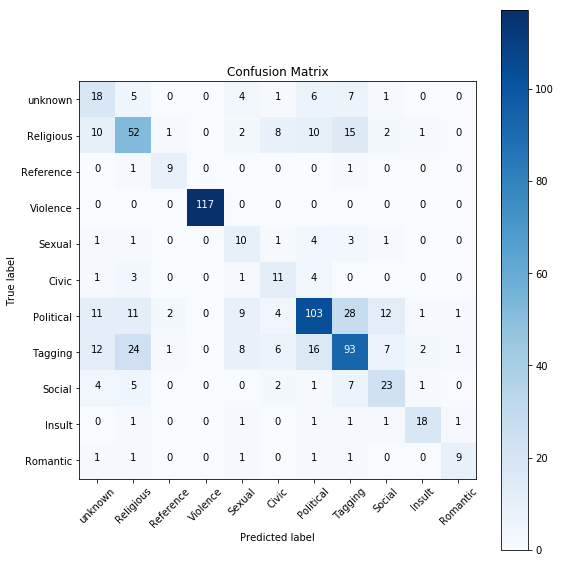

In [34]:
#Draw a figure
fig = plt.figure(figsize = (8,8))
#Call the custom function to draw the conf matrix
plot_conf_matrix(conf_matrix_train, classes = class_names)

In [49]:
print(classification_report(y_train, y_hat_train, target_names = class_names))

             precision    recall  f1-score   support

    unknown       0.43      0.31      0.36        58
   Violence       0.51      0.50      0.51       104
    Tagging       0.82      0.69      0.75        13
  Religious       1.00      1.00      1.00       117
   Romantic       0.48      0.28      0.35        36
     Social       0.55      0.33      0.42        33
      Civic       0.57      0.71      0.63       146
     Insult       0.55      0.60      0.57       156
     Sexual       0.53      0.49      0.51        47
  Political       0.75      0.78      0.77        23
  Reference       0.64      0.75      0.69        12

avg / total       0.62      0.62      0.61       745



Discuss

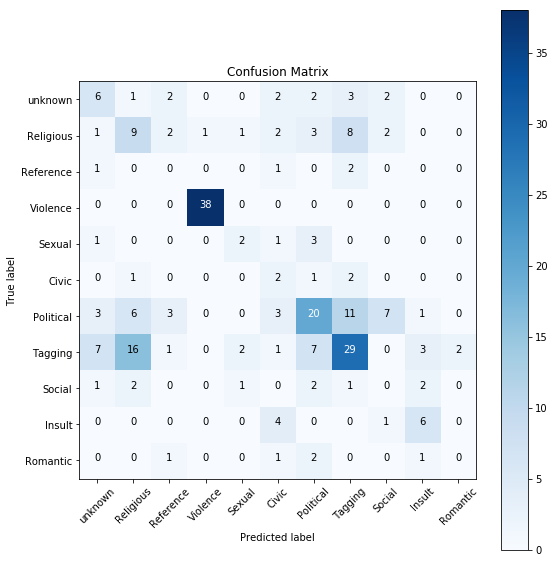

In [38]:
plt.figure(figsize = (8,8))
#Call the custom function to draw the conf matrix
plot_conf_matrix(conf_matrix_test, classes = class_names)

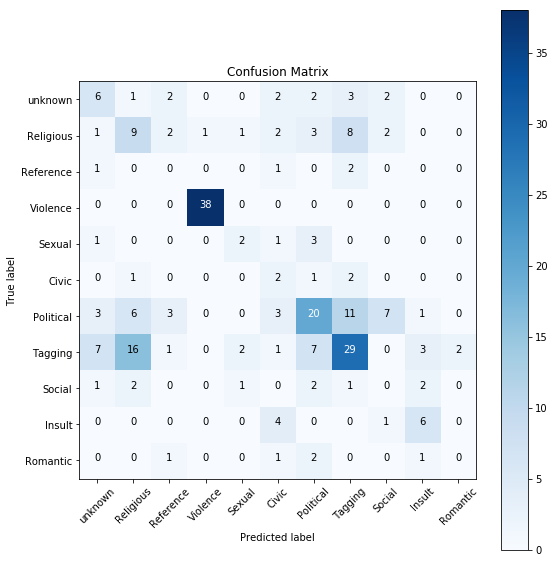

In [39]:
plt.figure(figsize = (8,8))
#Call the custom function to draw the conf matrix
plot_conf_matrix(conf_matrix_test, classes = class_names)

In [51]:
print(classification_report(y_test, y_hat_test, target_names = class_names))

             precision    recall  f1-score   support

    unknown       0.33      0.30      0.32        20
   Violence       0.31      0.26      0.28        35
    Tagging       0.00      0.00      0.00         9
  Religious       1.00      0.97      0.99        39
   Romantic       0.29      0.33      0.31         6
     Social       0.33      0.12      0.17        17
      Civic       0.37      0.50      0.43        40
     Insult       0.43      0.52      0.47        56
     Sexual       0.00      0.00      0.00        12
  Political       0.55      0.46      0.50        13
  Reference       0.00      0.00      0.00         2

avg / total       0.44      0.45      0.44       249



This model is almost useless! It only classifies 'Reference', 'Insult', and 'Violence.'
There is wide variation in its predictive ability from class to class.

<a id = 'detour_cat'></a>

### Detour: improving the categories

I'm unhappy with the categories and think I can do better.

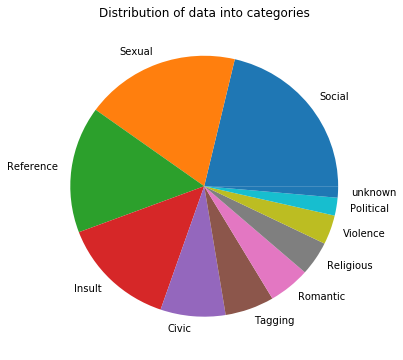

In [40]:
cat_counts = df_raw['Category'].value_counts()
fig = plt.figure(figsize = (6,6))
plt.pie(x = cat_counts, labels = cat_counts.index)
plt.title('Distribution of data into categories')
plt.show()

There are two problems to solve:

 1. Categories are imprecise. (What isn't "social"?)
 2. Data is unevenly distributed into these categories

Before I try to up- or down-sample I'd like to see if I can rearrange the data within the categories. I've browsed the English translations of the graffiti and have spotted some key words that I want to count the incidence of across the categories. This may suggest some more precise categories for the data. It may also allow for more even data distribution across categories.

In [30]:
#A new df for the reorganized categories
df_clean = copy.deepcopy(df_raw)

In [28]:
#A lambda function with the "globals" so I don't have to pass them in every time
pysqldf = lambda q: sqldf(q, globals())

categories = list(df_raw['Category'].unique())

#Some possible new categories
#Hoping to draw values out from 'Social'
love = ['the girls', 'love', 'venus']
slave = ['servant', 'serve', 'slave']
emperor = ['Caesar', 'emperor', 'Nero']
gods = ['Jupiter', 'god', 'holy', 'pray']
greeting = ['bye', 'hello', 'goodbye', 'greetings']
glory = ['fight', 'mars','soldier', 'victor']
########## WARNING!! NSFW ################
lewd = ['bugger', 'cock', 'cunt', 'faggot', 'fuck', 'suck']
###########################################
blessing = ['best wishes', 'bravo',  'favor', 'favour', 'good luck', 'happy', 'smile']
curse = ['anger', 'beware', 'curse']
keyword_cats = [love, slave, emperor, gods, greeting, glory, lewd, blessing, curse]

#A list of all keywords
keywords = []
for cat in keyword_cats:
    for word in cat:
        keywords.append(word)
        
#Build a 'keyword matrix' with my custom function
#to show incidence of the above keywords in the 
#original categories of the data.
keywords_df = keyword_matrix(pysqldf, categories, keywords)

In [56]:
keywords_df

,Key_Word,Religious,Civic,Insult,Reference,Tagging,Social,Sexual,Romantic,unknown,Political,Violence
0,the girls,0,0,0,0,4,0,1,0,0,0,1
1,love,3,0,2,18,0,0,2,40,0,0,0
2,venus,12,0,0,5,1,1,2,0,0,0,1
3,servant,0,0,1,0,0,1,0,0,0,0,0
4,serve,0,4,0,1,0,0,0,0,0,0,0
5,slave,2,2,4,0,3,5,7,1,0,1,0
6,Caesar,0,1,1,0,0,0,0,0,0,3,2
7,emperor,1,0,0,0,1,0,0,0,0,3,0
8,Nero,1,0,1,0,1,2,1,0,0,5,5
9,Jupiter,0,0,1,0,0,1,0,0,0,0,0


In [57]:
#Opportunity to knock off many of the values from 'Social.'
keywords_df['Social'].sum()

139

In [31]:
#Categorize greetings, blessings, and curses as Hails 
#Hello, goodbye, good luck, go to hell)
hails = []
for words in [greeting, blessing, curse]:
    for word in words:
        hails.append(word)
write(df_clean, hails, 'In English', 'Category', 'Hail')

#Categorize references to emperors or slaves as Political
poli = []
for words in [emperor, slave]:
    for word in words:
        poli.append(word)
write(df_clean, poli, 'In English', 'Category', 'Political')

#Categorize glory words as Violence
write(df_clean, glory, 'In English', 'Category', 'Violence')
#Categorize lewd words as Lewd (new category)
write(df_clean, lewd, 'In English', 'Category', 'Lewd')
#Categorize love words as Romantic
write(df_clean, love, 'In English', 'Category', 'Romantic')
#Categorize gods words as Religious
write(df_clean, gods, 'In English', 'Category', 'Religious')

#Now:
#Combine 'Violence' and 'Political' into 'Glory'
write(df_clean, ['Violence', 'Political'], 'Category', 'Category', 'Glory')
#Combine 'Sexual' and 'Romantic' into 'Love'
write(df_clean, ['Sexual', 'Romantic'], 'Category', 'Category', 'Love')
#Combine 'unknown' and 'Tagging' into 'Civic'
write(df_clean, ['unknown', 'Tagging'], 'Category', 'Category', 'Civic')
#Combine 'Insult' with 'Hail' (They're both direct adresses)
write(df_clean, ['Insult'], 'Category', 'Category', 'Hail')
#Combine 'Religious' with 'Glory' (Politics, War, and Religion are all heady)
write(df_clean, ['Religious'], 'Category', 'Category', 'Glory')

#Now:
#Give the final categories jazzier names
replacements = {'Reference': 'Literature',
                'Social': 'Gossip',
                'Civic': 'Bulletin',
                'Religion': 'Gods'
                }
df_clean['Category'] = df_clean['Category'].replace(replacements)

How did all this work affect our categories?

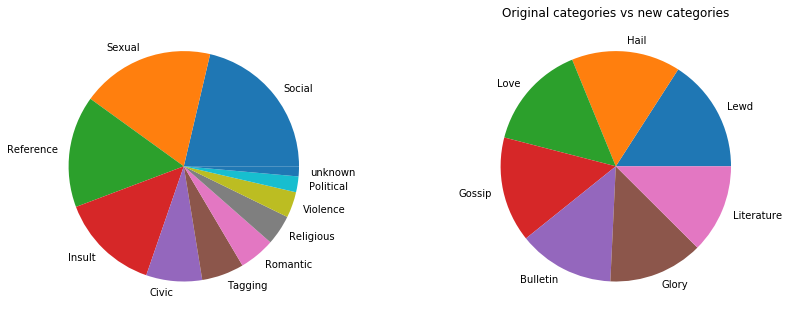

In [44]:
cat_counts = df_raw['Category'].value_counts()

#Values of old categories to count
cat_counts = df_raw['Category'].value_counts()
#Capture the values of the new categories to plot
v2cat_counts = df_clean['Category'].value_counts()

#Plot old categories side by side with new ones
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_axes([0, 0, .5, .5], aspect = 1)
ax1.pie(x = cat_counts, labels = cat_counts.index)
ax2 = fig.add_axes([0.5, 0, .5, .5], aspect = 1)
ax2.pie(x = v2cat_counts, labels = v2cat_counts.index)
#Need to fix title position
plt.title('Original categories vs new categories')
plt.show()

In [ ]:
df_clean['Category'].value_counts()

Much better!

__Lewd__: Swear words and body parts

In [49]:
df_clean[df_clean['Category'] == 'Lewd'][:3]

,CIL IV #,Reggio,Insula,Entrance,In English,Literacy,Position,Building Type,Famous House,Category,Writer,Flohr Score,Socio-economic status,Characters,Imperative,Address
8,10090,2,1,10,"Petronius, you fuck Pyramus",2,garden,house,0,Lewd,0,8.740000,low,27,0,2.1
11,10078,2,1,3,"Supremus, faggot: 4 a(sses). Bye, pussy!",2,room,house,0,Lewd,0,5.950000,low,40,1,2.1
21,4029,5,1,17,Here I fucked twice [...],2,facade,tabernae,0,Lewd,0,5.250497,low,25,0,5.1


__Hail__: Hello, goodbye, bless you, curse you

In [51]:
df_clean[df_clean['Category'] == 'Hail'][30:33]

,CIL IV #,Reggio,Insula,Entrance,In English,Literacy,Position,Building Type,Famous House,Category,Writer,Flohr Score,Socio-economic status,Characters,Imperative,Address
119,1841,8,1,1,"Whoever, you are forget the lost Greeks Narcis...",3,unknown,basilica,1,Hail,0,5.250497,low,62,1,8.1.1
120,1813,8,1,1,Woe you!,3,unknown,basilica,1,Hail,0,5.250497,low,8,1,8.1.1
121,1941,8,1,1,"You, who consider turning on the lamp, you hav...",3,unknown,basilica,1,Hail,0,5.250497,low,59,0,8.1.1


__Love__: Romance & sex

In [54]:
df_clean[df_clean['Category'] == 'Love'][63:66]

,CIL IV #,Reggio,Insula,Entrance,In English,Literacy,Position,Building Type,Famous House,Category,Writer,Flohr Score,Socio-economic status,Characters,Imperative,Address
451,1649,7,6,35,"Let him constrain the winds, whoever rebukes l...",3,unknown,tabernae,0,Love,0,1.730000,low,115,0,7.6
468,3711,9,6,7,"I, Hamillus, love Nothe this way",2,facade,unknown,0,Love,0,5.250497,low,32,0,9.6
476,8137,1,7,3,"My sweet love: may you die like this, I do lov...",3,room,house,1,Love,0,22.211636,high,80,0,1.7


__Gossip__: Have you heard who was drinking wine with Euphabia?

In [55]:
df_clean[df_clean['Category'] == 'Gossip'][:3]

,CIL IV #,Reggio,Insula,Entrance,In English,Literacy,Position,Building Type,Famous House,Category,Writer,Flohr Score,Socio-economic status,Characters,Imperative,Address
5,10079,2,1,6,Maximus (greets) his Irene,2,facade,tabernae,0,Gossip,0,3.37,low,26,0,2.1
14,1589-1590,5,1,7,"Aphrodite, mistress Euche, mistress",2,atrium,house,1,Gossip,0,0.00,medium,37,0,5.1
15,1592,5,1,7,"Genialis, Euche",2,atrium,house,1,Gossip,0,0.00,medium,15,0,5.1


__Bulletin__: I baked bread today; I sold some pots today

In [58]:
df_clean[df_clean['Category'] == 'Bulletin'][1:4]

,CIL IV #,Reggio,Insula,Entrance,In English,Literacy,Position,Building Type,Famous House,Category,Writer,Flohr Score,Socio-economic status,Characters,Imperative,Address
7,10088b,2,1,10,It's raining,2,garden,house,0,Bulletin,0,8.74,low,12,0,2.1
29,1239,6,1,26,"Hay brought the 18th of October, [...] pounds",3,entrance,house,0,Bulletin,0,52.54,high,45,0,6
34,2351,7,1,25,Polycarpus has escaped,2,atrium,house,0,Bulletin,0,15.28,low,22,0,7.1


__Glory__: The slaves won the battle! The emperor won the battle! The gods helped us win the battle!

In [61]:
df_clean[df_clean['Category'] == 'Glory'][16:19]

,CIL IV #,Reggio,Insula,Entrance,In English,Literacy,Position,Building Type,Famous House,Category,Writer,Flohr Score,Socio-economic status,Characters,Imperative,Address
75,1849a,8,1,1,Casaer dictator,2,unknown,basilica,1,Glory,0,5.250497,low,15,0,8.1.1
103,1847,8,1,1,"Rufius, slave of Sittius Publius, has painted ...",3,unknown,basilica,1,Glory,0,5.250497,low,128,0,8.1.1
117,1896,8,1,1,"When the ham is cooked, if it if it served to ...",3,unknown,basilica,1,Glory,1,5.250497,low,116,0,8.1.1


__Literature__: Ovid, Aenid, Homer, Horace: we've got all the classics

In [63]:
df_clean[df_clean['Category'] == 'Literature'][:3]

,CIL IV #,Reggio,Insula,Entrance,In English,Literacy,Position,Building Type,Famous House,Category,Writer,Flohr Score,Socio-economic status,Characters,Imperative,Address
3,10086a,2,1,10,Of arms and a man…,3,entrance,house,0,Literature,1,8.74,low,18,0,2.1
9,10096b,2,1,11,All fell silent…,3,outer wall,apartment,0,Literature,1,23.77,medium,16,0,2.1
12,10085,2,1,10,I sing the greatest songs of the man…,3,unknown,house,0,Literature,1,8.74,low,37,0,2.1


<a id ='char'></a>

## How useful will the character count be?

(array([ 77., 196., 184., 128.,  97.,  88.,  47.,  33.,  33.,  23.,  18.,
         21.,   5.,   9.,   8.,   4.,   2.,   2.,   4.,   2.,   2.,   0.,
          3.,   2.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([  3.  ,  12.34,  21.68,  31.02,  40.36,  49.7 ,  59.04,  68.38,
         77.72,  87.06,  96.4 , 105.74, 115.08, 124.42, 133.76, 143.1 ,
        152.44, 161.78, 171.12, 180.46, 189.8 , 199.14, 208.48, 217.82,
        227.16, 236.5 , 245.84, 255.18, 264.52, 273.86, 283.2 , 292.54,
        301.88, 311.22, 320.56, 329.9 , 339.24, 348.58, 357.92, 367.26,
        376.6 , 385.94, 395.28, 404.62, 413.96, 423.3 , 432.64, 441.98,
        451.32, 460.66, 470.  ]),
 <a list of 50 Patch objects>)

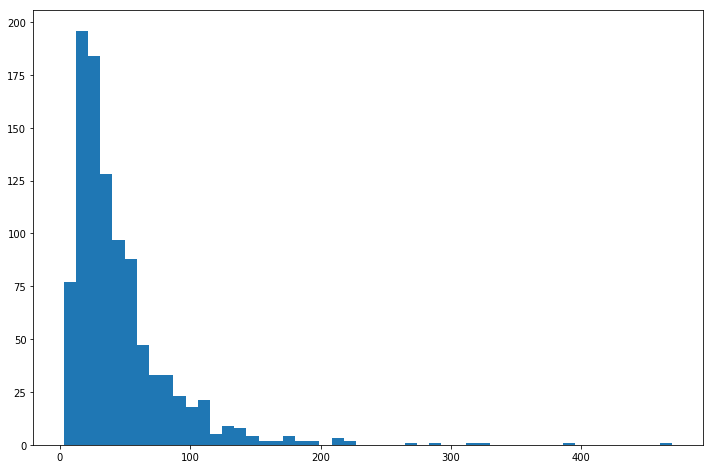

In [163]:
#Look at the distribution of character counts
fig = plt.figure(figsize = (12,8))
plt.hist(df_clean['Characters'], bins = 50)

A lot of clustering around the lower values.

In [176]:
#Which characters have frequencies greater than 20?
df_clean['Characters'].value_counts()[df_clean['Characters'].value_counts().values > 20]

21    28
19    27
25    27
33    24
17    23
30    22
20    22
13    21
24    21
16    21
Name: Characters, dtype: int64

Let's remove the characters between 13 and 33 to get a look at the less-densely-clusetered values.

In [32]:
#Get rows where character count is less than 13 or
#greater than 33
char = (df_clean['Characters'] > 33) | (df_clean['Characters'] < 13)

char_Lewd = df_clean[(df_clean['Category'] == 'Lewd')
                    & (char)]['Characters']

char_Hail = df_clean[(df_clean['Category'] == 'Hail') 
                     & (char)]['Characters']

char_Love = df_clean[(df_clean['Category'] == 'Love') 
                     & (char)]['Characters']

char_Gossip = df_clean[(df_clean['Category'] == 'Gossip') 
                       & (char)]['Characters']

char_Bulletin = df_clean[(df_clean['Category'] == 'Bulletin') 
                         & (char)]['Characters']

char_Glory = df_clean[(df_clean['Category'] == 'Glory') 
                      & (char)]['Characters']

char_Literature = df_clean[(df_clean['Category'] == 'Literature') 
                           & (char)]['Characters']

In [37]:
char_Lewd.shape[0]

66

In [43]:
#Visualize distribution of characters counts among the categories
#as a scatter plot. Leaving this as optional in case the histograms 
#are confusing. I liked the histograms better.
#fig = plt.figure(figsize = (12, 8))
#plt.scatter(range(char_Lewd.shape[0]), char_Lewd, color = 'red', label = 'Lewd')
#plt.scatter(range(char_Hail.shape[0]), char_Hail, color = 'orange', label = 'Hail')
#plt.scatter(range(char_Love.shape[0]), char_Love, color = 'yellow', label = 'Love')
#plt.scatter(range(char_Gossip.shape[0]), char_Gossip, color = 'green', label = 'Gossip')
#plt.scatter(range(char_Bulletin.shape[0]), char_Bulletin, color = 'blue', label = 'Bulletin')
#plt.scatter(range(char_Glory.shape[0]), char_Glory, color = 'purple', label = 'Glory')
#plt.scatter(range(char_Literature.shape[0]), char_Literature, color = 'black', label = 'Literature')
#plt.legend()

/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


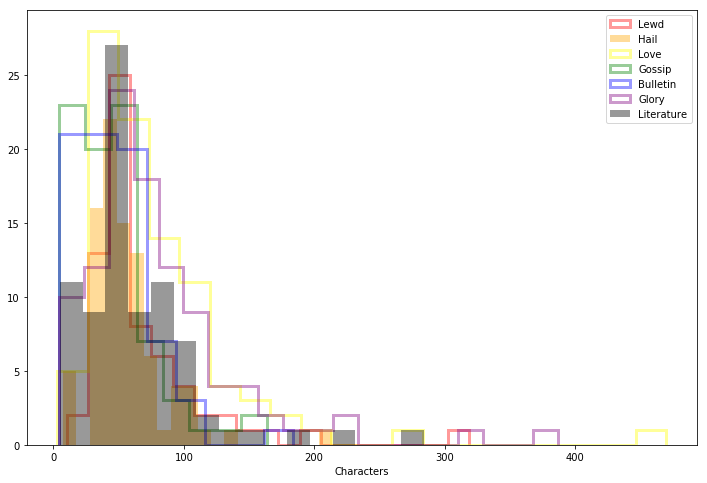

In [33]:
#Visualize distribution of characters counts among the categories
fig = plt.figure(figsize = (12, 8))
sns.distplot(char_Lewd, color = 'red', kde = False,
              hist_kws = {'histtype': 'step', 'linewidth': 3},
             label = 'Lewd')
sns.distplot(char_Hail, color = 'orange', kde = False, label = 'Hail')
sns.distplot(char_Love, color = 'yellow', kde = False, 
              hist_kws = {'histtype': 'step', 'linewidth': 3},
             label = 'Love')
sns.distplot(char_Gossip, color = 'green', kde = False, 
              hist_kws = {'histtype': 'step', 'linewidth': 3},
             label = 'Gossip')
sns.distplot(char_Bulletin, color = 'blue', kde = False,
              hist_kws = {'histtype': 'step', 'linewidth': 3},
             label = 'Bulletin')
sns.distplot(char_Glory, color = 'purple', kde = False,
              hist_kws = {'histtype': 'step', 'linewidth': 3},
             label = 'Glory')
sns.distplot(char_Literature, color = 'black', kde = False, label = 'Literature')
plt.legend()

Still tight clustering by all categories. I doubt this feature will be important for classifying but we can leave it in to see how it does in the models.

<a id ='flohr'></a>

## How useful will the Flohr score be?

(array([388.,  91., 300., 108.,   5.,  26.,  29.,  19.,  11.,  17.]),
 array([ 0.   ,  8.382, 16.764, 25.146, 33.528, 41.91 , 50.292, 58.674,
        67.056, 75.438, 83.82 ]),
 <a list of 10 Patch objects>)

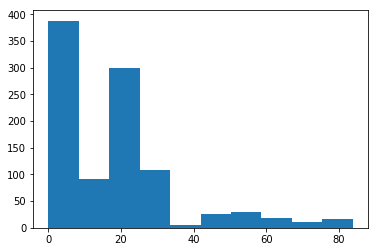

In [131]:
plt.hist(df_clean['Flohr Score'])

Most of the Flohr scores are less than 6. We're interested in the distribution of the scores greater than 6 among our categories. How well well these Flohr scores indicate the category of a graffito?

In [45]:
#Capture distribution of Flohr scores above 6 
#for each category of graffiti
flohr_gt6 = df_clean['Flohr Score'] > 6

flohr_Lewd = df_clean[(df_clean['Category'] == 'Lewd')
                 & (flohr_gt6)]['Flohr Score']

flohr_Hail = df_clean[(df_clean['Category'] == 'Hail')
                 & (flohr_gt6)]['Flohr Score']

flohr_Love = df_clean[(df_clean['Category'] == 'Love')
                 & (flohr_gt6)]['Flohr Score']

flohr_Gossip = df_clean[(df_clean['Category'] == 'Gossip')
                 & (flohr_gt6)]['Flohr Score']

flohr_Bulletin = df_clean[(df_clean['Category'] == 'Bulletin')
                 & (flohr_gt6)]['Flohr Score']

flohr_Glory = df_clean[(df_clean['Category'] == 'Glory')
                 & (flohr_gt6)]['Flohr Score']

flohr_Literature = df_clean[(df_clean['Category'] == 'Literature')
                 & (flohr_gt6)]['Flohr Score']   

In [48]:
#Visualize all the categories' distributions of Flohr scores together as a scatter.
#Leaving this as optoinal in case the histogram looks confusing.
#I liked the histogram better.
#fig = plt.figure(figsize = (12, 8))
#plt.scatter(range(flohr_Lewd.shape[0]), flohr_Lewd, color = 'red', label = 'Lewd')
#plt.scatter(range(flohr_Hail.shape[0]), flohr_Hail, color = 'orange', label = 'Hail')
#plt.scatter(range(flohr_Love.shape[0]), flohr_Love, color = 'yellow', label = 'Love')
#plt.scatter(range(flohr_Gossip.shape[0]), flohr_Gossip, color = 'green', label = 'Gossip')
#plt.scatter(range(flohr_Glory.shape[0]), flohr_Glory, color = 'blue', label = 'Glory')
#plt.scatter(range(flohr_Bulletin.shape[0]), flohr_Bulletin, color = 'purple', label = 'Bulletin')
#plt.scatter(range(flohr_Literature.shape[0]), flohr_Literature, color = 'black', label = 'Literature')
#plt.legend()

C:\Users\Stee\Anaconda3good\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


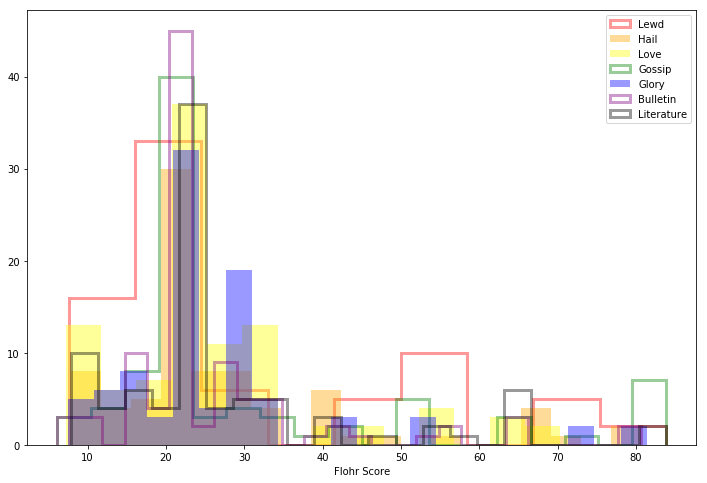

In [205]:
#Visualize all the categories' distributions of Flohr scores together
fig = plt.figure(figsize = (12, 8))
sns.distplot(flohr_Lewd, color = 'red', 
             hist_kws = {'histtype': 'step', 'linewidth': 3}, 
             kde = False, label = 'Lewd')
sns.distplot(flohr_Hail, color = 'orange', kde = False, label = 'Hail')
sns.distplot(flohr_Love, color = 'yellow', kde = False, label = 'Love')
sns.distplot(flohr_Gossip, color = 'green',
             hist_kws = {'histtype': 'step', 'linewidth': 3},
             kde = False, label = 'Gossip')
sns.distplot(flohr_Glory, color = 'blue', kde = False, label = 'Glory')
sns.distplot(flohr_Bulletin, color = 'purple', 
             hist_kws = {'histtype': 'step', 'linewidth': 3},
             kde = False, label = 'Bulletin')
sns.distplot(flohr_Literature, color = 'black',
              hist_kws = {'histtype': 'step', 'linewidth': 3},
             kde = False, label = 'Literature')

plt.legend()

Lots of clustering around Flohr score of 20. This is discouraging: would be better for our classifier if each category had many of its values at a different Flohr from the othe categories.

But visual inspection shows a few high concentrations.

- Glory: 25 - 30
- Love: 30 - 35
- Lewd: 50 - 60
- Gossip: 90


We've explored the data and have some sense of how the features will signal our categories. Now let's see how this data performs with a plain vanilla logistic regression model.

In [45]:
#To track the score from model to model
score_columns = ['set', 'precision', 'recall', 'f1']
#Instantiate a generic score df
score_df = pd.DataFrame(columns = score_columns)

# Modeling

A simple model is often the best. We'll try simple classification models first. If they don't perform well enough, we can upgrade to more high-tech models.

<a id = 'model1'></a>

[(Back to top)](#top)

# Model #1: Logistic regression
### Prepare the data

In [210]:
df = copy.deepcopy(df_clean)

#Make categories
df['Literacy'] = df['Literacy'].astype('category')
df['Position'] = df['Position'].astype('category')
df['Building Type'] = df['Building Type'].astype('category')
df['Famous House'] = df['Famous House'].astype('bool').astype('category')
df['Socio-economic status'] = df['Socio-economic status'].astype('category')
df['Writer'] = df['Writer'].astype('bool').astype('category')
df['Category'] = df['Category'].astype('category')
df['Imperative'] = df['Imperative'].astype('bool').astype('category')
df['Address'] = df['Address'].astype('category')
#Continuous data: 'Characters', 'Flohr Score'

#Get dummies
literacy_dummies = pd.get_dummies(df['Literacy'], prefix = 'Literacy')
position_dummies = pd.get_dummies(df['Position'], prefix = 'Position')
build_type_dummies = pd.get_dummies(df['Building Type'], prefix = 'Building_Type')
famous_dummies = pd.get_dummies(df['Famous House'], prefix = 'Famous')
econ_status_dummies = pd.get_dummies(df['Socio-economic status'], prefix = 'Econ_Status')
writer_dummies = pd.get_dummies(df['Writer'], prefix = 'Writer')
imperative_dummies = pd.get_dummies(df['Imperative'], prefix = 'Imperative')
address_dummies = pd.get_dummies(df['Address'], prefix = 'Address')

X = df.drop(['CIL IV #', 'Reggio', 'Insula', 'Entrance', 'Literacy', 'In English', 
             'Position', 'Building Type', 
             'Famous House', 'Category', 'Socio-economic status',
             'Writer', 'Imperative', 'Address'
            ], axis = 1)
X = pd.concat([X, literacy_dummies, position_dummies, build_type_dummies, 
               famous_dummies, econ_status_dummies, writer_dummies,
             imperative_dummies, address_dummies
              ], axis = 1)

y = df['Category']

#Create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12)
#print(y_train.value_counts(),'\n', y_test.value_counts())

### Build a model

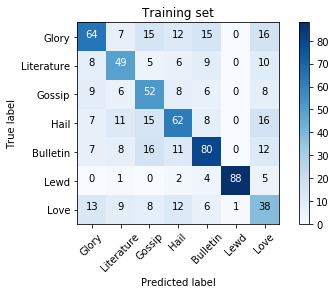

In [65]:
#Build a logistic regression model
first_lr = LogisticRegression(fit_intercept=False, C=1e16)
#Fit the classifier to the training data
first_lr.fit(X_train, y_train)
#Generate predicted y values for training set
first_lr_y_hat_train = first_lr.predict(X_train)
#Generate predicted y values for testing set
first_lr_y_hat_test = first_lr.predict(X_test)

#Create a confusion matrix for the training set
first_lr_conf_matrix_train = confusion_matrix(first_lr_y_hat_train, y_train)
#Create a confusion matrix for the testing set
first_lr_conf_matrix_test = confusion_matrix(first_lr_y_hat_test, y_test)

#Create labels for the classes in the conf matrix
class_names = set(y)
#Draw a figure
#plt.figure(figsize = (8,8))
#Call the custom function to draw the conf matrix
plot_conf_matrix(first_lr_conf_matrix_train, title = 'Training set', classes = class_names)

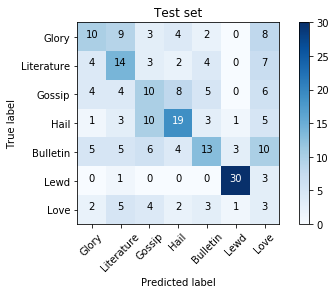

In [66]:
#plt.figure(figsize = (8,8))
#Call the custom function to draw the conf matrix
plot_conf_matrix(first_lr_conf_matrix_test, title = 'Test set', classes = class_names)

In [67]:
print('First model training set:')
print(classification_report(y_train, first_lr_y_hat_train, target_names = class_names))
print('First model testing set:')
print(classification_report(y_test, first_lr_y_hat_test, target_names = class_names))

First model training set:
             precision    recall  f1-score   support

      Glory       0.50      0.59      0.54       108
 Literature       0.56      0.54      0.55        91
     Gossip       0.58      0.47      0.52       111
       Hail       0.52      0.55      0.53       113
   Bulletin       0.60      0.62      0.61       128
       Lewd       0.88      0.99      0.93        89
       Love       0.44      0.36      0.40       105

avg / total       0.58      0.58      0.58       745

First model testing set:
             precision    recall  f1-score   support

      Glory       0.28      0.38      0.32        26
 Literature       0.41      0.34      0.37        41
     Gossip       0.27      0.28      0.27        36
       Hail       0.45      0.49      0.47        39
   Bulletin       0.28      0.43      0.34        30
       Lewd       0.88      0.86      0.87        35
       Love       0.15      0.07      0.10        42

avg / total       0.39      0.40      0.39 

The first model could only classify 3 out of 11 categories. The second model can classify all 7 of its categories, and it does a good job on 4 out of 7 although its mean scores a bit lower than the first. There is less variation in predictive ability from column to column, a step toward a better model.

Maybe we can hone the model by adjusting a few of its parameters?

<a id = 'logreg_regparam'></a>

[(Back to top)](#top)

## Logistic regression: adjusting the regularization parameter

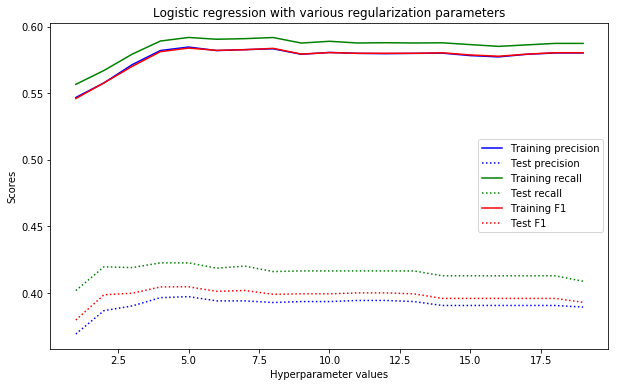

In [67]:
#A range of regularization parameters to try
params = np.arange(1, 20, 1)

#Build a df to hold the scores for each iteration
#Set up columns for a new df to hold scores
score_columns = ['param_values', 'prec_train', 'prec_test', 
                     'recall_train', 'recall_test', 'f1_train', 'f1_test']
    
#Instantiate adf to use for storing scores
lr_scores_df = pd.DataFrame(columns = score_columns)

#Run a model for each parameter and record
#its scores in the df
for param in params:
    #Build a logistic regression model
    lr = LogisticRegression(fit_intercept = True, C = param)
    #Fit the classifier to the training data
    lr.fit(X_train, y_train)
    #Generate predicted y values for training set
    lr_y_hat_train = lr.predict(X_train)
    #Generate predicted y values for testing set
    lr_y_hat_test = lr.predict(X_test)
    
    #Get the scores
    prec_train = precision_score(y_train, lr_y_hat_train, average = None).mean()
    prec_test = precision_score(y_test, lr_y_hat_test, average = None).mean()
    recall_train = recall_score(y_train, lr_y_hat_train, average = None).mean()
    recall_test =  recall_score(y_test, lr_y_hat_test, average = None).mean()
    f1_train = f1_score(y_train, lr_y_hat_train, average = None).mean()
    f1_test = f1_score(y_test, lr_y_hat_test, average = None).mean()
    
    #Write the scores to the df
    lr_scores_df = lr_scores_df.append({'param_values': param,
               'prec_train': prec_train,
               'prec_test': prec_test,
               'recall_train': recall_train,
               'recall_test': recall_test,
               'f1_train': f1_train,
               'f1_test': f1_test              
              }, ignore_index = True)
    
#Visualize all attempts together
plot_hypers(lr_scores_df, 'Logistic regression with various regularization parameters')

In [41]:
lr_scores_df.head(8)

,param_values,prec_train,prec_test,recall_train,recall_test,f1_train,f1_test
0,1.0,0.489348,0.362278,0.500148,0.395449,0.485794,0.369075
1,2.0,0.488170,0.365125,0.498557,0.394406,0.485234,0.370836
2,3.0,0.494664,0.361401,0.504122,0.388912,0.492536,0.365810
3,4.0,0.492749,0.371979,0.501594,0.401554,0.490365,0.377090
4,5.0,0.488027,0.370737,0.497743,0.397472,0.486459,0.374813
5,6.0,0.484766,0.368817,0.494075,0.393569,0.482683,0.371015
6,7.0,0.486506,0.372064,0.495362,0.398331,0.484208,0.374876
7,8.0,0.485630,0.379248,0.494040,0.401732,0.483128,0.379966


The scores for the test sets all peak at a regularization parameter of 2 but haven't really risen above the scores of the earlier models.

<a id = 'logreg_cv'></a>

[(Back to top)](#top)

## Logistic regression: cross validation

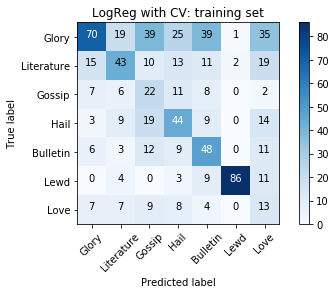

In [211]:
#Fit the training data to a logistic regression classifier with cross validation
#class weight 'balanced' allowed it to classify one more class
lrcv = LogisticRegressionCV(class_weight = 'balanced', 
                            multi_class = 'multinomial'
                           ).fit(X_train, y_train)

#Predict y values for training and test sets
lrcv_y_hat_train = lrcv.predict(X_train)
lrcv_y_hat_test = lrcv.predict(X_test)

#Create a confusion matrix for the training set
lrcv_conf_matrix_train = confusion_matrix(lrcv_y_hat_train, y_train)
#Create a confusion matrix for the test set
lrcv_conf_matrix_test = confusion_matrix(lrcv_y_hat_test, y_test)

#Draw a confusion matrix for the training set
plot_conf_matrix(lrcv_conf_matrix_train, title = 'LogReg with CV: training set', classes = class_names)

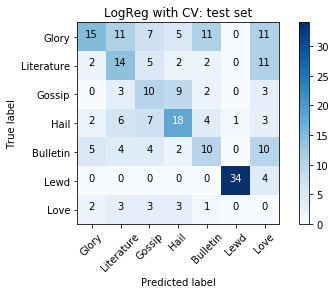

In [212]:
#Draw a confusion matrix for the test set
plot_conf_matrix(lrcv_conf_matrix_test, title = 'LogReg with CV: test set', classes = class_names)

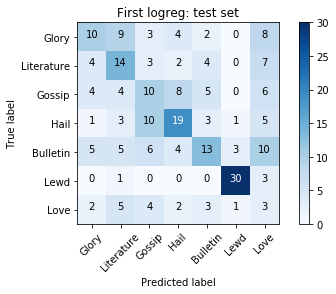

In [213]:
#Compare to plain vanilla logreg
plot_conf_matrix(first_lr_conf_matrix_test, title = 'First logreg: test set', classes = class_names)

In [214]:
print('LogReg with CV, training set:')
print(classification_report(y_train, lrcv_y_hat_train, target_names = class_names))
print('LogReg with CV, testing set:')
print(classification_report(y_test, lrcv_y_hat_test, target_names = class_names))

LogReg with CV, training set:
             precision    recall  f1-score   support

      Glory       0.31      0.65      0.42       108
 Literature       0.38      0.47      0.42        91
     Gossip       0.39      0.20      0.26       111
       Hail       0.45      0.39      0.42       113
   Bulletin       0.54      0.38      0.44       128
       Lewd       0.76      0.97      0.85        89
       Love       0.27      0.12      0.17       105

avg / total       0.44      0.44      0.42       745

LogReg with CV, testing set:
             precision    recall  f1-score   support

      Glory       0.25      0.58      0.35        26
 Literature       0.39      0.34      0.36        41
     Gossip       0.37      0.28      0.32        36
       Hail       0.44      0.46      0.45        39
   Bulletin       0.29      0.33      0.31        30
       Lewd       0.89      0.97      0.93        35
       Love       0.00      0.00      0.00        42

avg / total       0.37      0.41   

The model with cross validation does not perform any better than the original logistic regression.

<a id = 'logreg_final'></a>

## The final logistic regression model

In [215]:
print('Model:',type(lrcv))
print('Folds:', lrcv.n_iter_.shape[1])

Model: <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>
Folds: 3


With logistic regression we haven't been able to get scores above 40%. This data may be better suited to a decision tree.

In [216]:
#Record scores to show in conclusions
logreg_df = copy.deepcopy(score_df)
logreg_df = write_scores(logreg_df, y_train, lrcv_y_hat_train, y_test, lrcv_y_hat_test)

<a id = 'model2'></a>

[(Back to top)](#top)

# Model #2: Decision tree

## A plain vanilla decision tree

In [221]:
# Train the classifier and make predictions
first_tree = DecisionTreeClassifier(criterion = 'entropy')
first_tree.fit(X_train,y_train) 
first_tree_y_hat_train = first_tree.predict(X_train)
first_tree_y_hat_test = first_tree.predict(X_test)

### Visualize the result

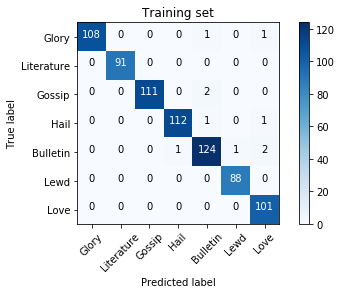

In [222]:
#Create confusion matrices with the results

class_names = set(df['Category'])

#A CM for the training set
first_tree_conf_matrix_train = confusion_matrix(first_tree_y_hat_train, y_train)
#A CM for the test set
first_tree_conf_matrix_test = confusion_matrix(first_tree_y_hat_test, y_test)

#Draw the training CM
plot_conf_matrix(first_tree_conf_matrix_train, title = 'Training set', classes = class_names)

Very over-fitted!

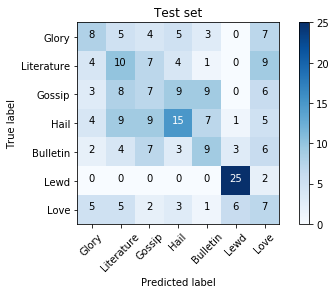

In [223]:
#Draw the test CM
plot_conf_matrix(first_tree_conf_matrix_test, title = 'Test set', classes = class_names)

In [225]:
print(classification_report(y_test, first_tree_y_hat_test, target_names = class_names))

             precision    recall  f1-score   support

      Glory       0.25      0.31      0.28        26
 Literature       0.29      0.24      0.26        41
     Gossip       0.17      0.19      0.18        36
       Hail       0.30      0.38      0.34        39
   Bulletin       0.26      0.30      0.28        30
       Lewd       0.93      0.71      0.81        35
       Love       0.24      0.17      0.20        42

avg / total       0.35      0.33      0.33       249



In [226]:
#MAybe useful for interpreting graph
print('Features:', first_tree.n_features_)
print('Tree depth:', first_tree.tree_.max_depth)
print('Nodes and leaves:', first_tree.tree_.node_count)
print('"Capacity":', first_tree.tree_.capacity)

Features: 104
Tree depth: 26
Nodes and leaves: 799
"Capacity": 799


An out-of-the-box decision performs no better on this data than logistic regression. The tree is very complex: deep and wide with lots of nodes.

Perhaps we can break the 40% score by tuning hyperparameters of the tree.

<a id = 'tree_tuning_hypers'></a>

[(Back to top)](#top)

## Decision tree: tuning hyperparameters

### Compare values of max_depth

In [89]:
print('Max depth of original tree:', clf.tree_.max_depth)

Max depth of original tree: 26


C:\Users\Stee\Anaconda3good\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Stee\Anaconda3good\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


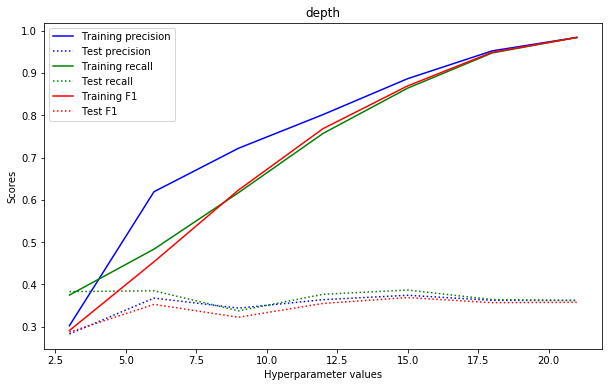

In [90]:
#Set values of chosen hyperparameter
depth_params = np.arange(3, 22, 3)
#Run model for each param value and store scores
depth_df = compare_hypers(depth_params, 'depth', X_train, X_test, y_train, y_test)
#Plot scores
plot_hypers(depth_df, 'depth')

In [91]:
depth_df

,param_values,prec_train,prec_test,recall_train,recall_test,f1_train,f1_test
0,3.0,0.302391,0.282867,0.374851,0.383038,0.290990,0.287046
1,6.0,0.619113,0.367743,0.483437,0.384920,0.453533,0.352775
2,9.0,0.721940,0.343950,0.616942,0.337469,0.623151,0.322454
3,12.0,0.801545,0.363958,0.756940,0.376678,0.768317,0.355069
4,15.0,0.886368,0.374384,0.863939,0.386748,0.869256,0.368934
5,18.0,0.952083,0.362369,0.947215,0.364320,0.948860,0.356858
6,21.0,0.983813,0.362186,0.983800,0.362013,0.983703,0.357662


Test set peaks at a depth of 15. (But only a very slight peak.)

### Compare values of min_samples_split

In [92]:
print('Min sample split of original tree:', 2 )

Min sample split of original tree: 2


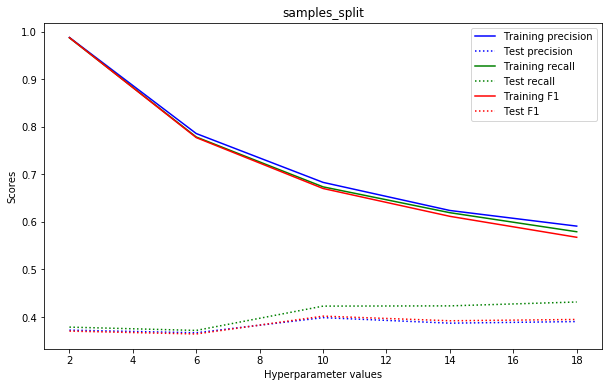

In [93]:
#Set values of chosen hyperparameter
samples_split_params = np.arange(2, 20, 4)
#Run model for each param value and store scores
samples_split_df = compare_hypers(samples_split_params, 'samples_split', X_train, X_test, y_train, y_test)
#Plot scores
plot_hypers(samples_split_df, 'samples_split')

In [44]:
samples_split_df

,param_values,prec_train,prec_test,recall_train,recall_test,f1_train,f1_test
0,2.0,0.988250,0.338616,0.987582,0.360219,0.987819,0.340997
1,4.0,0.862982,0.371737,0.860074,0.388822,0.858197,0.371302
2,6.0,0.780057,0.388133,0.771995,0.397033,0.771845,0.381539
3,8.0,0.724944,0.390761,0.710846,0.398797,0.707856,0.379502
4,10.0,0.666627,0.405133,0.660669,0.421564,0.654478,0.398824
5,12.0,0.628235,0.416408,0.620344,0.442070,0.608602,0.409847
6,14.0,0.619834,0.419035,0.612681,0.444804,0.600638,0.414121
7,16.0,0.607261,0.410985,0.595347,0.438810,0.579780,0.406754
8,18.0,0.584427,0.403562,0.570118,0.434546,0.554446,0.398038


10 minimum samples to split.

### Compare values of min_samples_leaf

C:\Users\Stee\Anaconda3good\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Stee\Anaconda3good\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


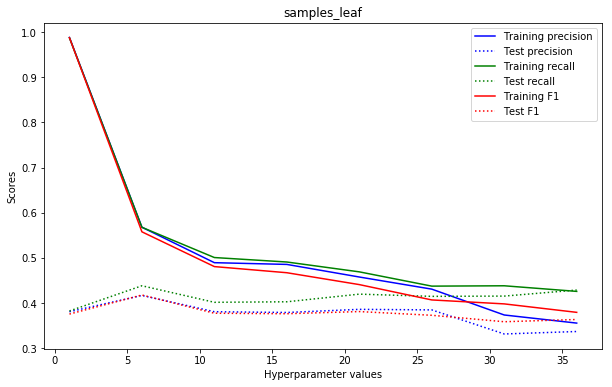

In [94]:
#Set values of chosen hyperparameter
samples_leaf_params = np.arange(1, 40, 5)
#Run model for each param value and store scores
samples_leaf_df = compare_hypers(samples_leaf_params, 'samples_leaf', X_train, X_test, y_train, y_test)
#Plot scores
plot_hypers(samples_leaf_df, 'samples_leaf')

*Observations*: The test set seems to reach a peak at 6 samples per leaf.

### Compare values of max_features

In [95]:
print('Features in the original tree:', clf.n_features_)

Features in the original tree: 104


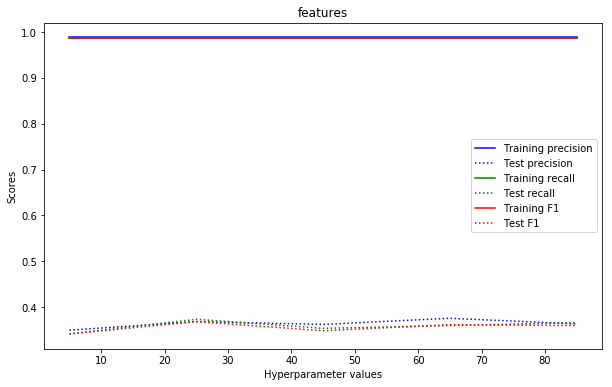

In [96]:
#Set values of chosen hyperparameter
feature_params = np.arange(5, 105, 20)
#Run model for each param value and store scores
feature_df = compare_hypers(feature_params, 'features', X_train, X_test, y_train, y_test)
#Plot scores
plot_hypers(feature_df, 'features')

In [55]:
feature_df

,param_values,prec_train,prec_test,recall_train,recall_test,f1_train,f1_test
0,5.0,0.98825,0.390014,0.987582,0.384861,0.987819,0.383297
1,15.0,0.98825,0.340477,0.987582,0.335394,0.987819,0.334314
2,25.0,0.98825,0.357527,0.987582,0.361711,0.987819,0.357852
3,35.0,0.98825,0.342921,0.987582,0.356537,0.987819,0.342394
4,45.0,0.98825,0.322142,0.987582,0.338374,0.987819,0.326596
5,55.0,0.98825,0.327529,0.987582,0.342351,0.987819,0.328718


*Observations*: Scores are highest when there are only 25 features. But they're only slightly higher. At this point I don't know which features are being selected. I'd hope it were the ones at the top of the tree.

### Compare values of max_leaf_nodes

In [97]:
print('Nodes and leaves in original tree:', clf.tree_.node_count)

Nodes and leaves in original tree: 735


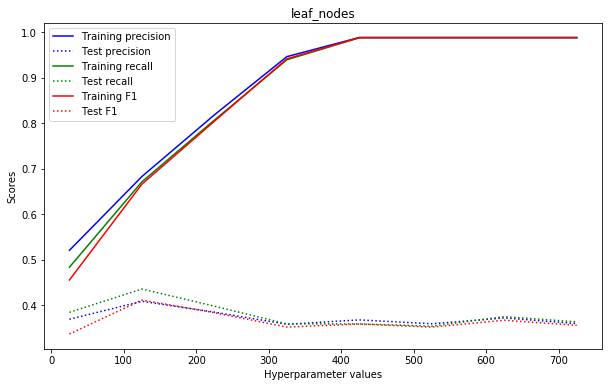

In [98]:
#Set values of chosen hyperparameter
leaf_nodes_params = np.arange(25, 800, 100)
#Run model for each param value and store scores
leaf_nodes_df = compare_hypers(leaf_nodes_params, 'leaf_nodes', X_train, X_test, y_train, y_test)
#Plot scores
plot_hypers(leaf_nodes_df, 'leaf_nodes')

In [60]:
leaf_nodes_df

,param_values,prec_train,prec_test,recall_train,recall_test,f1_train,f1_test
0,25.0,0.575957,0.415111,0.488729,0.412375,0.457281,0.371352
1,125.0,0.709131,0.384044,0.695475,0.402490,0.691680,0.383131
2,225.0,0.844061,0.346611,0.833554,0.365653,0.831933,0.349736
3,325.0,0.955666,0.329450,0.953181,0.337586,0.953489,0.327815
4,425.0,0.988250,0.335428,0.987582,0.346898,0.987819,0.336210
5,525.0,0.988250,0.356551,0.987582,0.373387,0.987819,0.357614
6,625.0,0.988250,0.365203,0.987582,0.381063,0.987819,0.365432
7,725.0,0.988250,0.363551,0.987582,0.376460,0.987819,0.363482


*Observations*: The test set gets the best results when the tree has about 125 leaves and nodes.

### Compare values of min_impurity_decrease

C:\Users\Stee\Anaconda3good\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Stee\Anaconda3good\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


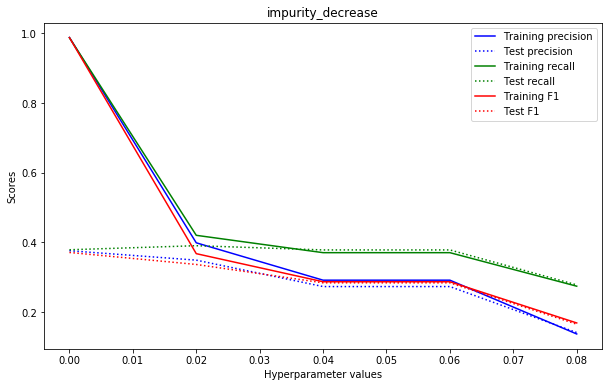

In [99]:
#Set values of chosen hyperparameter
impurity_decrease_params = np.arange(0, .1, .02)
#Run model for each param value and store scores
impurity_decrease_df = compare_hypers(impurity_decrease_params, 'impurity_decrease', X_train, X_test, y_train, y_test)
#Plot scores
plot_hypers(impurity_decrease_df, 'impurity_decrease')

*Observations*: Test set does best at impurity decrease of 0.02.

### Hyperparameter tuning summary

- criterion: entropy
- max_depth: 15. (But only a very slight peak.)
- min_samples_split: 10
- min_samples_leaf: 6
- max_features: 25
- max_leaf_node: about 125
- min_impurity_decrease: 0.02

The most obvious conclusion is that the test set cannot break past 40% by any measure and with any individual hyperparameter tuned.

Perhaps a combination found with a GridSearch could get past 40%?

<a id = 'tree_grid_search'></a>

[(Back to top)](#top)

## Decision tree: tuning hyperparameters with Grid Search CV

In [100]:
#Instantiate a new tree
clf = DecisionTreeClassifier()

param_grid = {
    'criterion': ["gini", "entropy"],
    'max_depth': depth_params,
    'min_samples_split': samples_split_params,
    'min_samples_leaf': samples_leaf_params,
    'max_features': feature_params,
    'max_leaf_nodes': leaf_nodes_params,
    'min_impurity_decrease': impurity_decrease_params
    }

gs_tree = GridSearchCV(clf, param_grid, cv=3)

In [102]:
start = time.time()
gs_tree.fit(X_train,  y_train)
end = time.time()
print(end - start)

1158.0284674167633


In [103]:
tree_best_params = gs_tree.best_params_

In [104]:
#newest run
tree_best_params

{'criterion': 'gini',
 'max_depth': 9,
 'max_features': 85,
 'max_leaf_nodes': 125,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 16,
 'min_samples_split': 6}

*Compare to visual inspection*

- criterion: entropy
- max_depth: 12. (But only a very slight peak.)
- max_features: 15
- max_leaf_node: about 125
- min_impurity_decrease: 0.02
- min_samples_leaf: 6
- min_samples_split: 14

In [105]:
#Get scores for grid search
gs_training_score = np.mean(gs_tree.cv_results_['mean_train_score'])
gs_testing_score = gs_tree.score(X, y)

print("Mean Training Score: {:.4}%".format(gs_training_score * 100))
print("Mean Testing Score: {:.4}%".format(gs_testing_score * 100))

Mean Training Score: 30.27%
Mean Testing Score: 45.57%


C:\Users\Stee\Anaconda3good\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Grid search seems to have found hyperparameters that allow our model to break 40%. Let's build that model.

<a id = 'tree_final'></a>

[(Back to top)](#top)

## Decision tree: the final model

In [108]:
tree_best_params

{'criterion': 'gini',
 'max_depth': 9,
 'max_features': 85,
 'max_leaf_nodes': 125,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 16,
 'min_samples_split': 6}

In [231]:
# Train the classifier and make predictions
final_tree = DecisionTreeClassifier(
                criterion = 'entropy',
                max_depth = 9,
                max_features = 60,
                max_leaf_nodes = 125,
                min_impurity_decrease = 0.0,
                min_samples_leaf = 16,
                min_samples_split = 6
            )
final_tree.fit(X_train,y_train) 
final_tree_y_hat_train = final_tree.predict(X_train)
final_tree_y_hat_test = final_tree.predict(X_test)

class_names = set(df['Category'])

#A CM for the training set
final_tree_conf_matrix_train = confusion_matrix(final_tree_y_hat_train, y_train)
#A CM for the test set
final_tree_conf_matrix_test = confusion_matrix(final_tree_y_hat_test, y_test)

#Score reports
final_tree_train_report = classification_report(y_train, final_tree_y_hat_train, target_names = class_names)
final_tree_test_report = classification_report(y_test, final_tree_y_hat_test, target_names = class_names)
print('Training set:')
print(final_tree_train_report)
print('Test set:')
print(final_tree_test_report)

Training set:
             precision    recall  f1-score   support

      Glory       0.39      0.41      0.40       108
 Literature       0.44      0.31      0.36        91
     Gossip       0.38      0.20      0.26       111
       Hail       0.47      0.41      0.44       113
   Bulletin       0.38      0.62      0.47       128
       Lewd       0.76      0.99      0.86        89
       Love       0.31      0.26      0.28       105

avg / total       0.44      0.45      0.43       745

Test set:
             precision    recall  f1-score   support

      Glory       0.27      0.31      0.29        26
 Literature       0.38      0.24      0.30        41
     Gossip       0.27      0.17      0.21        36
       Hail       0.49      0.51      0.50        39
   Bulletin       0.28      0.63      0.38        30
       Lewd       0.89      0.94      0.92        35
       Love       0.25      0.14      0.18        42

avg / total       0.41      0.41      0.39       249



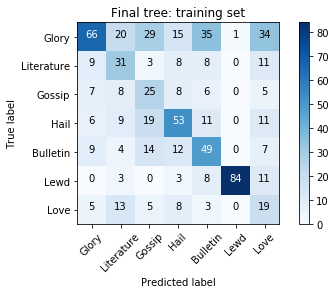

In [81]:
plot_conf_matrix(final_tree_conf_matrix_train, title = 'Final tree: training set', classes = class_names)

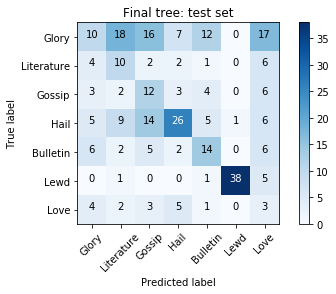

In [82]:
plot_conf_matrix(final_tree_conf_matrix_test, title = 'Final tree: test set', classes = class_names)

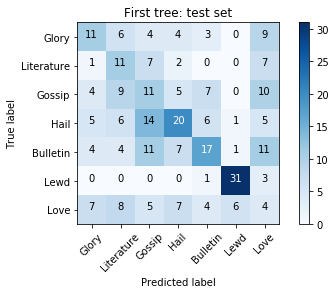

In [88]:
#Compare to first tree test set:
plot_conf_matrix(first_tree_conf_matrix_test, title = 'First tree: test set', classes = class_names)

This decision tree with its hyperparameters tuned has pushed up the scores a little bit but enough for the model to be useful in practice. This data -- a small, noise set -- may require some more sophisticated modeling.

In [232]:
#Record scores to show in conclusions
tree_df = copy.deepcopy(score_df)
tree_df = write_scores(tree_df, y_train, final_tree_y_hat_train, y_test, final_tree_y_hat_test)

<a id = 'model3'></a>

[(Back to top)](#top)

# Model \#3: Random Forest

A Random Forest is a collection of decision trees. Each tree in the forest gets  a subset of the features and a subset of the data to build its own classifier. The trees all 'vote' on how to classify a given row of data. Intuitively, the decision reached by a majority in 100 different models should be better than that reached by any individual model.

In [247]:
#Build a Random Forest
forest = RandomForestClassifier(n_estimators=175, 
                                max_depth = 30, 
                                bootstrap = True
                               )
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=175, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [248]:
forest_y_hat_train = forest.predict(X_train)
forest_y_hat_test = forest.predict(X_test)

In [249]:
print('Tree trainig set')
print(classification_report(y_train, forest_y_hat_train))
print('Tree test set')
print(classification_report(y_test, forest_y_hat_test))

Tree trainig set
             precision    recall  f1-score   support

   Bulletin       0.99      0.99      0.99       108
      Glory       1.00      1.00      1.00        91
     Gossip       0.99      0.99      0.99       111
       Hail       0.98      0.99      0.99       113
       Lewd       0.96      0.98      0.97       128
 Literature       0.99      1.00      0.99        89
       Love       1.00      0.96      0.98       105

avg / total       0.99      0.99      0.99       745

Tree test set
             precision    recall  f1-score   support

   Bulletin       0.31      0.38      0.34        26
      Glory       0.40      0.29      0.34        41
     Gossip       0.27      0.33      0.30        36
       Hail       0.39      0.49      0.43        39
       Lewd       0.48      0.47      0.47        30
 Literature       0.91      0.91      0.91        35
       Love       0.37      0.26      0.31        42

avg / total       0.45      0.44      0.44       249



Text(0,0.5,'Feature')

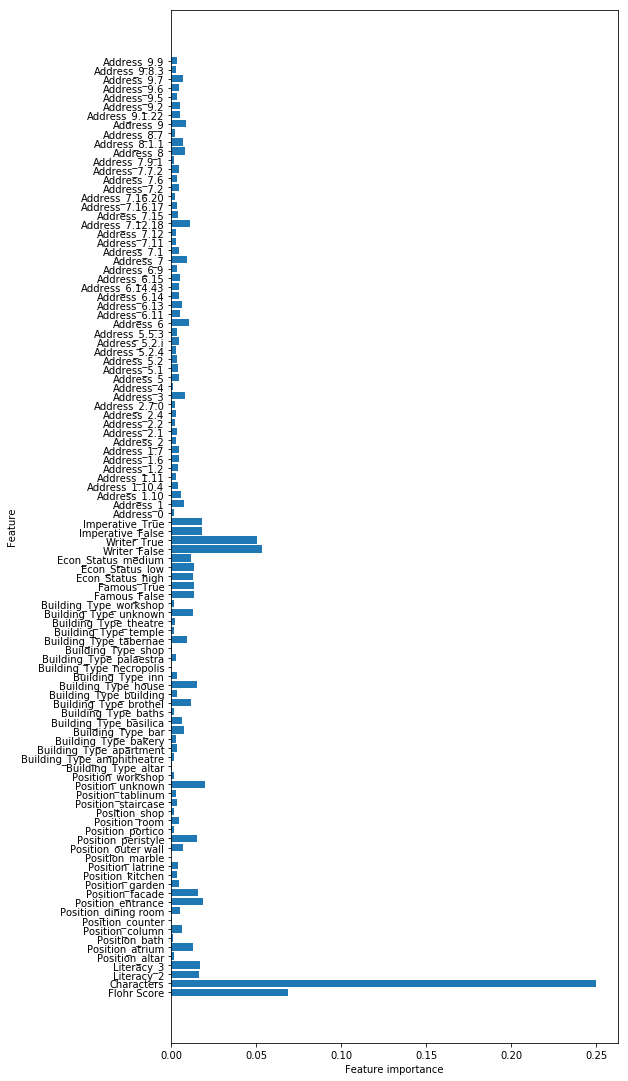

In [153]:
#Visualize feature importances
n_features = X_train.shape[1]
plt.figure(figsize=(8,19))
plt.barh(range(n_features), forest.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_train.columns.values) 
plt.xlabel("Feature importance")
plt.ylabel("Feature")

In [102]:
print('Trees:', len(forest.estimators_))

Trees: 175


<a id = 'forest_final'></a>

## The final random forest model

In [250]:
print('Trees:', len(forest.estimators_))
print('Features:', forest.n_features_)
print('Depth:', forest.max_features)

Trees: 175
Features: 104
Depth: auto


The forest improved on the scores of the logistic regression and the decision tree but the change was not dramatic. I'm beginning to think that we may not be able to build a model that will break scores of 50% with this data. But it will be worth trying one more.

In [251]:
#Record scores to show in conclusions
forest_scores = copy.deepcopy(score_df)
forest_scores = write_scores(forest_scores, y_train, forest_y_hat_train,
                            y_test, forest_y_hat_test)

<a id = 'model4'></a>

[(Back to top)](#top)

# Model 4: Gradient Boosting

Gradient Boosting constructs a forest of decision trees but it is not a "random" forest. The model uses gradient descent: the error of a tree in predicting a given row of data is the signal used to adjust the parameters of the next tree. The iterative improvements should produce a forest of trees that can classify even the most difficult datum.

In [296]:
#Build a GradientBoosting Classifier with a smaller learning rate
boost = GradientBoostingClassifier(learning_rate = 0.01)
#Fit the training data to the model
boost.fit(X_train, y_train)
#Predict ys for training and test sets
boost_y_hat_train = boost.predict(X_train)
boost_y_hat_test = boost.predict(X_test)

print('Tree trainig set')
print(classification_report(y_train, boost_y_hat_train))
print('Tree test set')
print(classification_report(y_test, boost_y_hat_test))

print('Mean Gradient Boosting Cross-Validation Score(k = 5):')
print(cross_val_score(boost, X, y, cv = 5).mean())

Tree trainig set
             precision    recall  f1-score   support

   Bulletin       0.38      0.70      0.50       108
      Glory       0.55      0.56      0.56        91
     Gossip       0.56      0.37      0.45       111
       Hail       0.55      0.57      0.56       113
       Lewd       0.59      0.51      0.55       128
 Literature       0.80      1.00      0.89        89
       Love       0.73      0.31      0.44       105

avg / total       0.59      0.56      0.55       745

Tree test set
             precision    recall  f1-score   support

   Bulletin       0.29      0.65      0.40        26
      Glory       0.36      0.32      0.34        41
     Gossip       0.39      0.25      0.31        36
       Hail       0.47      0.56      0.51        39
       Lewd       0.30      0.40      0.34        30
 Literature       0.88      0.86      0.87        35
       Love       0.36      0.10      0.15        42

avg / total       0.44      0.43      0.41       249

Mean Grad

<a id = 'boost_gs'></a>

## Gradient Boosting with Grid Search

In [287]:
learning_rate = np.arange(0.01, 0.1, 0.02)
max_depth = np.arange(5, 20, 5)
max_features = np.arange(20, 100, 20)
n_estimators = np.arange(100, 250, 50)

In [288]:
Combinations = 3 * len(learning_rate) * len(max_features) * len(max_depth) * len(n_estimators)
Combinations

540

In [289]:
param_grid = {
    'learning_rate': learning_rate,
    'max_features': max_features,
    'max_depth': max_depth,
    'max_features': feature_params,
    'n_estimators': n_estimators
    }

gs_boost = GridSearchCV(boost, param_grid, cv=3)

In [290]:
start = time.time()
gs_boost.fit(X_train,  y_train)
end = time.time()
gs_boost_time = end - start

TypeError: unsupported operand type(s) for /: 'GridSearchCV' and 'int'

In [291]:
print('Took', (gs_boost_time / 60), 'minutes')

Took 72.25413269996643 minutes


In [292]:
gs_boost.best_params_

{'learning_rate': 0.01,
 'max_depth': 5,
 'max_features': 65,
 'n_estimators': 150}

I tried another model with these parameters but wasn't satisfied. I tweaked them a little more and got higher scores.

In [315]:
#Build a GradientBoosting Classifier with new hyperparameters
boost_wgs = GradientBoostingClassifier(learning_rate = 0.01,
                                       max_depth = 5,
                                       max_features = 20,
                                       n_estimators = 100
                                 )
#Fit the training data to the model
boost_wgs.fit(X_train, y_train)
#Predict ys for training and test sets
boost_wgs_y_hat_train = boost_wgs.predict(X_train)
boost_wgs_y_hat_test = boost_wgs.predict(X_test)

print('Tree trainig set')
print(classification_report(y_train, boost_wgs_y_hat_train))
print('Tree test set')
print(classification_report(y_test, boost_wgs_y_hat_test))

Tree trainig set
             precision    recall  f1-score   support

   Bulletin       0.48      0.88      0.62       108
      Glory       0.80      0.58      0.68        91
     Gossip       0.79      0.49      0.60       111
       Hail       0.68      0.73      0.71       113
       Lewd       0.70      0.63      0.66       128
 Literature       0.83      1.00      0.91        89
       Love       0.80      0.53      0.64       105

avg / total       0.72      0.69      0.68       745

Tree test set
             precision    recall  f1-score   support

   Bulletin       0.26      0.58      0.36        26
      Glory       0.44      0.27      0.33        41
     Gossip       0.41      0.31      0.35        36
       Hail       0.47      0.56      0.51        39
       Lewd       0.35      0.43      0.39        30
 Literature       0.89      0.97      0.93        35
       Love       0.47      0.19      0.27        42

avg / total       0.48      0.46      0.45       249

Mean Grad

This is our highest-scoring model yet. And it only uses 20 features at each split! Which 20 came up most often?

In [321]:
#Dict of column names and their importance
boost_wgs_features_importances = dict(zip(X.columns, boost_wgs.feature_importances_))
#Sort the feature importances
sorted_boost_wgs_importances = sorted(boost_wgs_features_importances.items(), key=lambda kv: kv[1])
#Display the top 20 features
sorted_importances[-20:]

[('Address_1', 0.009054948900382104),
 ('Building_Type_tabernae', 0.00963000532817043),
 ('Econ_Status_high', 0.010511988843263787),
 ('Address_8.1.1', 0.011554979899055472),
 ('Position_atrium', 0.0122424868556764),
 ('Address_7', 0.012741922985778358),
 ('Position_facade', 0.01582572539313597),
 ('Position_entrance', 0.015855855614829738),
 ('Building_Type_unknown', 0.016835664364777753),
 ('Position_unknown', 0.01683979095783825),
 ('Position_peristyle', 0.018149569049724083),
 ('Literacy_2', 0.020487982600455184),
 ('Imperative_False', 0.021123426940500362),
 ('Building_Type_house', 0.02206494095390565),
 ('Literacy_3', 0.02561720975519753),
 ('Famous_True', 0.025647848240300482),
 ('Building_Type_brothel', 0.027271537466655997),
 ('Flohr Score', 0.06778255451262012),
 ('Writer_False', 0.10654225320630306),
 ('Characters', 0.2677887736903846)]

Flohr Score, Writer, and Characters are once again at the top.

In [316]:
#Record scores to show in conclusions
boost_scores = copy.deepcopy(score_df)
boost_scores = write_scores(boost_scores, y_train, boost_wgs_y_hat_train,
                            y_test, boost_wgs_y_hat_test)

<a id = 'conclusions'></a>

[(Back to top)](#top)

# Conclusions

<a id = 'concl_comparisons'></a>

## Comparisons of models

### Logistic regression

In [217]:
print('Model:', type(lrcv))
print('Iterations:', lrcv.n_iter_.shape[2])
print('Folds:', lrcv.n_iter_.shape[1])
logreg_df

Model: <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>
Iterations: 10
Folds: 3


,precision,recall,f1
set,,,
training,0.442944,0.453337,0.426084
test,0.375534,0.423209,0.388448


### Decision tree

In [254]:
#tree_best_params
                #criterion = 'entropy',
                #max_depth = 9,
                #max_features = 60,
                #max_leaf_nodes = 125,
                #min_impurity_decrease = 0.0,
                #min_samples_leaf = 16,
                #min_samples_split = 6

In [234]:
tree_df

,precision,recall,f1
set,,,
training,0.446565,0.454782,0.437910
test,0.404153,0.421447,0.396206


### Random forest

In [253]:
print('Trees:', len(forest.estimators_))
print('Features:', forest.n_features_)
forest_scores

Trees: 175
Features: 104


,precision,recall,f1
set,,,
training,0.987802,0.987336,0.987501
test,0.448099,0.448667,0.444156


### Gradient Boosting

In [317]:
boost_scores

,precision,recall,f1
set,,,
training,0.727460,0.692742,0.688856
test,0.470113,0.472873,0.448866


### Comparisons of models: conclusions

Gradient boosting had the best performance. But scores of 48% - 50% mean that the classifier would only work half the time. This is better than the 14% expected from random guessing but still not good enough for rigorous archeology.

<a id = 'concl_features'></a>

## Feature importance

While buiding the earlier models I noticed that the features most closely linked to text content, e.g. Writer and Character Length, seemed to be having a larger effect than other features. This proved to be true when we plotted the feature importance for the Random Forest. The Addresses that I worked hard to create did not have much more effect than Socio-Economic Status or Literacy. 

The Random Forest model and Gradient Boosting model had the same most important features.

The third most important feature was the Flohr Score. The second most important was Writer_False, an indicator that a graffito was not a literary reference. And the most important feature of all was Character Length. These three far outweighed all the others.

![feature%20importance.png](https://raw.githubusercontent.com/ssrosa/cacator_cave_malum/master/images/feature%20importance.png)

<a id = 'concl_recs'></a>

## Recommendations

What does this tell us? Apparently, no matter how much information we have about a given grafitto's spatial surroundings, we will still need information about its content to classify it. Our best effort at a non-contextual classifer will go some way toward helping classify graffiti, but it won't be nearly as useful as a classifier that takes advantage of translations.

We recommend focusing on early translation of catalogued graffiti before more attempts are made to classify it. It is likely that we will be able to build a much simpler and more powerful classifier when we can take advatange of textual content analysis with natural language processing.

How about an example? In Reggio V, Insula 5, there is a famous house, the House of Gladiators.

![gladiators%20map.png](https://raw.githubusercontent.com/ssrosa/cacator_cave_malum/master/images/gladiators%20map.png)

Drawing constructed with maps [via](https://pompeiiinpictures.com/pompeiiinpictures/index.htm)

![house_of_gladiators.jpg](https://raw.githubusercontent.com/ssrosa/cacator_cave_malum/master/images/house_of_gladiators.jpg)

The peristyle (courtyard with columns) of the House of the Gladiators. image [via](http://www.pompeiiinpictures.com/pompeiiinpictures/R5/5%2005%2003%20p1.htm)

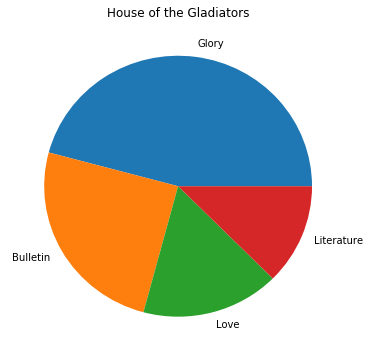

In [291]:
#Get categories of graffiti for House of the Gladiators
gladiators = df[df['Address'] == '5.5.3']['Category'].value_counts()
#Get only value  counts greater than 0
gladiators = gladiators[gladiators > 0]
fig = plt.figure(figsize = (6,6))
plt.pie(x = gladiators.values, labels = gladiators.index)
plt.title('House of the Gladiators')
plt.show()

Plenty of examples of "Glory" graffiti describing gladiator bouts were found in the peristyle.

But the people who used this house also wrote messages like "Be noble!", and "Dare everything!" They quoted from Virgil in the Aeneid, and they declared who "the girls sigh about." Their lives were rich and varied. To build a good classifier for their graffiti, we must know what they were writing about.

#### Analysis by Steven Rosa
#### [github](http://github.com/ssrosa) | [Medium](http://medium.com/@ssrosa) | [LinkedIn](http://linkedin.com/in/ssrosa)